In [84]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce
import datetime


In [85]:
L = 5 #system size
l=1 #spin length
M = -0.35
m_epsilon = 0
N=3
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [86]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
       0.         |2 2 2 2 2>           242  
       1.         |2 2 2 2 1>           241  
       2.         |2 2 2 2 0>           240  
       3.         |2 2 2 1 2>           239  
       4.         |2 2 2 1 1>           238  
       5.         |2 2 2 1 0>           237  
       6.         |2 2 2 0 2>           236  
       7.         |2 2 2 0 1>           235  
       8.         |2 2 2 0 0>           234  
       9.         |2 2 1 2 2>           233  
      10.         |2 2 1 2 1>           232  
      11.         |2 2 1 2 0>           231  
      12.         |2 2 1 1 2>           230  
      13.         |2 2 1 1 1>           229  
      14.         |2 2 1 1 0>           228  
      15.         |2 2 1 0 2>           227  
      16.         |2 2 1 0 1>           226  
      17.         |2 2 1 0 0>           225  
      18.         |2 2 0 2 2>           224  
      19.         |2 2 0 2 1>           223  
      20.  

In [87]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [88]:
B = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(int(4*l)+1)
b[int(2*l)+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.        ]
[0. 0. 0. 1. 0.]


In [89]:
C = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(int(4*l)+1)
c[int(2*l)] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [90]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [91]:
A = np.zeros((int(2*l)+1,int(2*l)+1), dtype = complex)
for i in range(int(2*l)+1):
    for j in range(int(2*l)+1):
        A[i][j] = (-l+i)**j
b = np.zeros(int(2*l)+1,dtype = complex)
for i in range(int(2*l)+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(int(2*3/2)+1, dtype = complex)
for i in range(int(2*l)+1):
    x[i] = solution[i]
print(x)
print(x.conj())

[ 1.+0.j  0.+0.j -2.-0.j  0.+0.j]
[ 1.-0.j  0.-0.j -2.+0.j  0.-0.j]


In [92]:
D = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(int(4*l)+1)
d[int(2*l)] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [93]:
E = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(int(4*l)+1)
e[int(2*l)-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.        ]
[0. 1. 0. 0. 0.]


In [94]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [95]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []

const_term_conj = []
linear_term_conj = []
quadratic_term_conj = []
cubic_term_conj = []

interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])

    const_term_conj.append([[x.conj()[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term_conj.append([[x.conj()[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term_conj.append([[x.conj()[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term_conj.append([[x.conj()[3]/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])


    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],


    ])

    interaction_m.append([
        ["-", const_term_conj[i]],
        ["-z", linear_term_conj[i]],
        ["-zz", quadratic_term_conj[i]],
        ["-zzz", cubic_term_conj[i]],


    ])
    
const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])
const_term_conj.append([[(0.5*np.conj((-1)**m_epsilon))/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term_conj[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns),dtype = complex) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(L+1):
    full_ham_matrix = (Proj[i]+Proj_0[i])@full_ham_matrix@(Proj[i]+Proj_0[i])
full_ham_matrix = 1.*full_ham_matrix

G=0
for i in range(L+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= 1*(full_ham_matrix + constraint_full_matrix) #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [96]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])


[-2.00142096 -1.46230785 -1.1410947 ]


In [97]:
#s_xy = [[1.,i,i+1] for i in range(L-1)]
#s_z = [[0.47,i] for i in range(L)]

#ham_map = [
    
#    ["xx",s_xy],
#    ["yy",s_xy],
#    ["z",s_z],


#]

#XYZ = hamiltonian(ham_map,dynamic_list=[],basis=basis,**no_checks)


In [98]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_r(i,j,phi,theta):
    sigma_r = sparse.identity(basis.Ns,dtype = complex)
    sigma_r = rot_sigma(0,i,j,phi,theta)@rot_sigma(L-1,i,j,phi,theta)
    return(sigma_r)


def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    for k in range(1,int(L/2)):
        sigma_e +=sigma(2*k,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    for k in range(int(L/2)):
        sigma_o +=sigma(2*k+1,i,j,phi)
    return sigma_o

def sigma_r(i,j,phi):
    sigma_r = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_r = sparse.csc_matrix(sigma_r)
    sigma_r = sigma(0,i,j,phi)+sigma(L-1,i,j,phi)
    return sigma_r

In [99]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

    
def ms_hamiltonian_1(i,j,phi):
    sigma_p = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_m = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_z = np.zeros((2*l+1,2*l+1),dtype = complex)
    
    sigma_p[2*l-j][2*l-i] = 1.
    sigma_m[2*l-i][2*l-j] = 1.
    
    sigma_z[2*l-i][2*l-i] = 1.
    sigma_z[2*l-j][2*l-j] = -1.
    
    sigma_p = sparse.csc_matrix(sigma_p)
    sigma_m = sparse.csc_matrix(sigma_m)
    sigma_z = sparse.csc_matrix(sigma_z)

    sigma_big_p = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_m = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_z = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]

    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    
    for k in range(L):
        if k == 0:
            tensprod_p = sigma_p
            tensprod_m = sigma_m
            tensprod_z = sigma_z

            for m in range(L-1):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()
            tensprod_z = tensprod_z.toarray()
        else:
            tensprod_p = sparse.identity(2*l+1)
            tensprod_m = sparse.identity(2*l+1)
            tensprod_z = sparse.identity(2*l+1)
            
            for i in range(1,k):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = scipy.sparse.kron(tensprod_p,sigma_p)
            tensprod_m = scipy.sparse.kron(tensprod_m,sigma_m)
            tensprod_z = scipy.sparse.kron(tensprod_z,sigma_z)            
            for i in range(k+1,L):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()    
            tensprod_z = tensprod_z.toarray() 
            
        sigma_big_p[k] = tensprod_p
        sigma_big_m[k] = tensprod_m
        sigma_big_z[k] = tensprod_z

    for k in range(L):
        summe += 1.*sigma_big_z[k]
        for kk in range(k+1,L):
            summe += 1./np.abs(k-kk)**2*(sigma_big_p[k]@sigma_big_m[kk] + sigma_big_m[k]@sigma_big_p[kk])
    return summe
                
matrix_part_1 = ms_hamiltonian_1(1,2,0)
ms_ham_eigenval_1, ms_ham_eigenvec_1 = scipy.linalg.eigh(matrix_part_1)




def ms_gate_global_1(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_1[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_1@exponential@ms_ham_eigenvec_1.T.conj()

In [100]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [101]:
def R(i,theta):
    
    if i%11 == 0:
        return(ms_gate_global(theta))

    if i%11 == 1:
        return(ms_gate_global_1(theta))

    if i%11 == 2:
        return(rot_sigma_e(0,1,0,theta).toarray())


    if i%11 == 3:
        return(rot_sigma_e(0,2,0,theta).toarray())

    
    if i%11 == 4:
        return(rot_sigma_e(1,2,np.pi/2,theta).toarray())
    
    
    if i%11 == 5:
        return(rot_sigma_o(0,1,0,theta).toarray())


    if i%11 == 6:
        return(rot_sigma_o(0,2,0,theta).toarray())

    
    if i%11 == 7:
        return(rot_sigma_o(1,2,np.pi/2,theta).toarray())

    if i%11 == 8:
        return(rot_sigma_r(0,1,0,theta).toarray())


    if i%11 == 9:
        return(rot_sigma_r(0,2,0,theta).toarray())

    
    if i%11 == 10:
        return(rot_sigma_r(1,2,np.pi/2,theta).toarray())
    
def S(i):
    
    if i%11 == 0:
        return(-1j*matrix_part)
    
    if i%11 == 1:
        return(-1j*matrix_part_1)

    if i%11 == 2:
        return(-1j*sigma_e(0,1,0).toarray())

    
    if i%11 == 3:
        return(-1j*sigma_e(0,2,0).toarray())

    
    if i%11 == 4:
        return(-1j*sigma_e(1,2,np.pi/2).toarray())


     
    if i%11 == 5:
        return(-1j*sigma_o(0,1,0).toarray())

    
    if i%11 == 6:
        return(-1j*sigma_o(0,2,0).toarray())

    
    if i%11 == 7:
        return(-1j*sigma_o(1,2,np.pi/2).toarray())

     
    if i%11 == 8:
        return(-1j*sigma_r(0,1,0).toarray())

    
    if i%11 == 9:
        return(-1j*sigma_r(0,2,0).toarray())

    
    if i%11 == 10:
        return(-1j*sigma_r(1,2,np.pi/2).toarray())


In [102]:
coeff = 11

In [103]:
matr = full_ham_matrix.toarray()
ones = np.ones(coeff*N)
ID = np.identity(coeff*N)
psi_0_conj = np.conj(psi_0)
A = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
dd = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]

In [104]:
def rhs(t,theta):
    #A = [-1j*entanglement_ham.toarray()@exp_ent(theta[0]),-1j*sigma_z.toarray()@exp_sigma_z(theta[1]),-1j*sigma_x.toarray()@exp_sigma_x(theta[2]),-1j*sigma_z.toarray()@exp_sigma_z(theta[3])]
    #B = [exp_ent(theta[0]),exp_sigma_z(theta[1]),exp_sigma_x(theta[2]),exp_sigma_z(theta[3])]
    ID = np.identity(coeff*N)

    print(datetime.datetime.now())
    for k in range(coeff*N):
        A[k] = S(k)@R(k,theta[k])
        B[k] = R(k,theta[k])

    CC = np.einsum("i,ljk->iljk",np.ones(coeff*N),B)

    AA = np.einsum("ijk,il->iljk",A,ID)

    BB = np.einsum("ijk,il->iljk",B,ID)

    DD = CC-BB+AA

    for i in range(coeff*N):
        dd[i] = reduce(np.dot,DD[i])
    DD = np.array(dd)

    X = np.zeros((coeff*N,coeff*N),dtype = complex)
    Y = np.zeros(coeff*N,dtype = complex)

    BBB = reduce(np.dot,B)
    DD_d = np.einsum("kij->kji",DD.conj())
    BBB_dagger = BBB.conj().T

    
    
    psi_conj_d = np.einsum("m,imn->in",psi_0_conj,DD_d)
    psi_d = np.einsum("jnl,l->jn",DD,psi_0)
    
    psi_conj_b = np.einsum("m,mn->n",psi_0_conj,BBB_dagger)
    psi_b = np.einsum("lk,k->l",BBB,psi_0)

    X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

    Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)
    
    XX = np.einsum("il,l->i",psi_conj_d,psi_b)
    
    YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)
        
    YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
    YY = YY_1*YY_2
    XX = np.outer(XX,XX)
    X_r = 2*np.real(X+XX)
    Y_i = 2*np.real(Y+YY)
    result = -np.linalg.pinv(X_r,rcond = 1e-6)@Y_i
    print(datetime.datetime.now())

    print(t)

    return result

In [107]:
stepp = 2000
t_final = 15

In [108]:
time_domain = np.linspace(0, t_final, stepp)
Y = []

In [109]:
# RK-4 method
def rk4(x0,y0,xn,n):
    global Y

    # Calculating step size
    h = (xn-x0)/n

    #print('\n--------SOLUTION--------')
    #print('-------------------------')    
    #print('x0\ty0\tyn')
    #print('-------------------------')
    for i in range(n):
        k1 = h * (rhs(x0, y0))
        k2 = h * (rhs((x0+h/2), (y0+k1/2)))
        k3 = h * (rhs((x0+h/2), (y0+k2/2)))
        k4 = h * (rhs((x0+h), (y0+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        yn = y0 + k
        #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
        #print('-------------------------')
        y0 = yn
        x0 = x0+h
        Y.append(y0)
    
    #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

# Inputs
#print('Enter initial conditions:')
#x0 = float(input('x0 = '))
#y0 = float(input('y0 = '))

#print('Enter calculation point: ')
#xn = float(input('xn = '))

#print('Enter number of steps:')
#step = int(input('Number of steps = '))

# RK4 method call


In [110]:
start_point = 0.001*np.ones(coeff*N)
#for i in range(4*N):
#    start_point[i] += i/4*N
rk4(0,0.001*np.ones(coeff*N),t_final,stepp)


2022-07-25 13:19:55.763116
2022-07-25 13:19:58.010607
0
2022-07-25 13:19:58.015583
2022-07-25 13:20:00.184485
0.00375
2022-07-25 13:20:00.189546
2022-07-25 13:20:02.339626
0.00375
2022-07-25 13:20:02.344630
2022-07-25 13:20:04.516334
0.0075
2022-07-25 13:20:04.521995
2022-07-25 13:20:06.694608
0.0075
2022-07-25 13:20:06.699685
2022-07-25 13:20:08.924958
0.01125
2022-07-25 13:20:08.930119
2022-07-25 13:20:11.087815
0.01125
2022-07-25 13:20:11.092888
2022-07-25 13:20:13.256178
0.015
2022-07-25 13:20:13.261249
2022-07-25 13:20:15.447286
0.015
2022-07-25 13:20:15.452666
2022-07-25 13:20:17.633221
0.01875
2022-07-25 13:20:17.638840
2022-07-25 13:20:19.790375
0.01875
2022-07-25 13:20:19.795401
2022-07-25 13:20:21.954528
0.0225
2022-07-25 13:20:21.959505
2022-07-25 13:20:24.303269
0.0225
2022-07-25 13:20:24.310065
2022-07-25 13:20:26.922801
0.02625
2022-07-25 13:20:26.929228
2022-07-25 13:20:29.524234
0.02625
2022-07-25 13:20:29.531104
2022-07-25 13:20:32.122940
0.03
2022-07-25 13:20:32.12966

2022-07-25 13:25:04.180749
0.22125000000000014
2022-07-25 13:25:04.187413
2022-07-25 13:25:06.779210
0.22125000000000014
2022-07-25 13:25:06.785616
2022-07-25 13:25:09.344954
0.22500000000000014
2022-07-25 13:25:09.351704
2022-07-25 13:25:12.009848
0.22500000000000014
2022-07-25 13:25:12.016750
2022-07-25 13:25:14.746623
0.22875000000000015
2022-07-25 13:25:14.753403
2022-07-25 13:25:17.326808
0.22875000000000015
2022-07-25 13:25:17.333415
2022-07-25 13:25:19.911467
0.23250000000000015
2022-07-25 13:25:19.918318
2022-07-25 13:25:22.594610
0.23250000000000015
2022-07-25 13:25:22.602554
2022-07-25 13:25:25.523320
0.23625000000000015
2022-07-25 13:25:25.530185
2022-07-25 13:25:28.241429
0.23625000000000015
2022-07-25 13:25:28.247704
2022-07-25 13:25:30.866072
0.24000000000000016
2022-07-25 13:25:30.872946
2022-07-25 13:25:33.555574
0.24000000000000016
2022-07-25 13:25:33.562539
2022-07-25 13:25:36.301401
0.24375000000000016
2022-07-25 13:25:36.308187
2022-07-25 13:25:39.043160
0.243750000

2022-07-25 15:25:49.223828
0.4312500000000003
2022-07-25 15:25:49.231155
2022-07-25 15:25:53.090625
0.4312500000000003
2022-07-25 15:25:53.098954
2022-07-25 15:25:56.757488
0.43500000000000033
2022-07-25 15:25:56.764578
2022-07-25 15:26:00.016410
0.43500000000000033
2022-07-25 15:26:00.024569
2022-07-25 15:26:03.425583
0.4387500000000003
2022-07-25 15:26:03.432937
2022-07-25 15:26:06.648755
0.4387500000000003
2022-07-25 15:26:06.655299
2022-07-25 15:26:09.871282
0.44250000000000034
2022-07-25 15:26:09.877568
2022-07-25 15:26:13.883060
0.44250000000000034
2022-07-25 15:26:13.890652
2022-07-25 15:26:17.464608
0.4462500000000003
2022-07-25 15:26:17.472453
2022-07-25 15:26:20.699507
0.4462500000000003
2022-07-25 15:26:20.708104
2022-07-25 15:26:24.452312
0.45000000000000034
2022-07-25 15:26:24.459207
2022-07-25 15:26:27.496218
0.45000000000000034
2022-07-25 15:26:27.503417
2022-07-25 15:26:30.863478
0.4537500000000003
2022-07-25 15:26:30.871264
2022-07-25 15:26:34.060238
0.4537500000000003

2022-07-25 15:31:52.916694
0.6449999999999995
2022-07-25 15:31:52.925028
2022-07-25 15:31:56.739255
0.6449999999999995
2022-07-25 15:31:56.746569
2022-07-25 15:31:59.875736
0.6487499999999995
2022-07-25 15:31:59.882718
2022-07-25 15:32:03.222048
0.6487499999999995
2022-07-25 15:32:03.228982
2022-07-25 15:32:06.266318
0.6524999999999994
2022-07-25 15:32:06.273527
2022-07-25 15:32:09.431293
0.6524999999999994
2022-07-25 15:32:09.438646
2022-07-25 15:32:12.620036
0.6562499999999994
2022-07-25 15:32:12.627411
2022-07-25 15:32:16.593223
0.6562499999999994
2022-07-25 15:32:16.601209
2022-07-25 15:32:20.632455
0.6599999999999994
2022-07-25 15:32:20.640183
2022-07-25 15:32:24.332733
0.6599999999999994
2022-07-25 15:32:24.340195
2022-07-25 15:32:27.513162
0.6637499999999994
2022-07-25 15:32:27.520241
2022-07-25 15:32:30.808859
0.6637499999999994
2022-07-25 15:32:30.816730
2022-07-25 15:32:34.629696
0.6674999999999993
2022-07-25 15:32:34.636282
2022-07-25 15:32:37.789244
0.6674999999999993
2022-

2022-07-25 15:38:05.242709
0.8549999999999981
2022-07-25 15:38:05.250380
2022-07-25 15:38:08.934765
0.8587499999999981
2022-07-25 15:38:08.942308
2022-07-25 15:38:12.100406
0.8587499999999981
2022-07-25 15:38:12.108502
2022-07-25 15:38:15.263135
0.862499999999998
2022-07-25 15:38:15.270385
2022-07-25 15:38:18.687381
0.862499999999998
2022-07-25 15:38:18.694592
2022-07-25 15:38:21.992682
0.8662499999999981
2022-07-25 15:38:22.000256
2022-07-25 15:38:25.126097
0.8662499999999981
2022-07-25 15:38:25.133749
2022-07-25 15:38:28.275679
0.869999999999998
2022-07-25 15:38:28.283999
2022-07-25 15:38:31.408290
0.869999999999998
2022-07-25 15:38:31.415310
2022-07-25 15:38:34.560895
0.873749999999998
2022-07-25 15:38:34.568866
2022-07-25 15:38:37.683597
0.873749999999998
2022-07-25 15:38:37.691628
2022-07-25 15:38:40.815099
0.877499999999998
2022-07-25 15:38:40.821790
2022-07-25 15:38:43.973585
0.877499999999998
2022-07-25 15:38:43.981211
2022-07-25 15:38:47.160509
0.881249999999998
2022-07-25 15:

2022-07-25 15:44:22.563928
1.0687499999999976
2022-07-25 15:44:22.570837
2022-07-25 15:44:26.289153
1.0687499999999976
2022-07-25 15:44:26.296544
2022-07-25 15:44:30.377443
1.0724999999999978
2022-07-25 15:44:30.385001
2022-07-25 15:44:34.746347
1.0724999999999978
2022-07-25 15:44:34.754998
2022-07-25 15:44:38.875373
1.0762499999999977
2022-07-25 15:44:38.882274
2022-07-25 15:44:42.588911
1.0762499999999977
2022-07-25 15:44:42.595782
2022-07-25 15:44:45.861216
1.0799999999999979
2022-07-25 15:44:45.868622
2022-07-25 15:44:49.177584
1.0799999999999979
2022-07-25 15:44:49.187592
2022-07-25 15:44:53.198636
1.0837499999999978
2022-07-25 15:44:53.206906
2022-07-25 15:44:56.627057
1.0837499999999978
2022-07-25 15:44:56.635830
2022-07-25 15:45:00.563538
1.087499999999998
2022-07-25 15:45:00.572377
2022-07-25 15:45:04.734520
1.087499999999998
2022-07-25 15:45:04.743512
2022-07-25 15:45:08.875991
1.0912499999999978
2022-07-25 15:45:08.889118
2022-07-25 15:45:12.669297
1.0912499999999978
2022-07

2022-07-25 15:51:57.564911
1.2787499999999994
2022-07-25 15:51:57.572003
2022-07-25 15:52:01.881393
1.2824999999999995
2022-07-25 15:52:01.891486
2022-07-25 15:52:05.731878
1.2824999999999995
2022-07-25 15:52:05.740494
2022-07-25 15:52:09.859787
1.2862499999999994
2022-07-25 15:52:09.867089
2022-07-25 15:52:13.976798
1.2862499999999994
2022-07-25 15:52:13.983755
2022-07-25 15:52:18.050380
1.2899999999999996
2022-07-25 15:52:18.057048
2022-07-25 15:52:22.140078
1.2899999999999996
2022-07-25 15:52:22.148431
2022-07-25 15:52:26.266249
1.2937499999999995
2022-07-25 15:52:26.274563
2022-07-25 15:52:30.086810
1.2937499999999995
2022-07-25 15:52:30.093615
2022-07-25 15:52:34.515209
1.2974999999999997
2022-07-25 15:52:34.523502
2022-07-25 15:52:38.988517
1.2974999999999997
2022-07-25 15:52:38.997536
2022-07-25 15:52:43.264653
1.3012499999999996
2022-07-25 15:52:43.274087
2022-07-25 15:52:47.462855
1.3012499999999996
2022-07-25 15:52:47.470658
2022-07-25 15:52:51.494375
1.3049999999999997
2022-

2022-07-25 15:59:19.216615
1.4962500000000012
2022-07-25 15:59:19.224131
2022-07-25 15:59:22.659716
1.4962500000000012
2022-07-25 15:59:22.666837
2022-07-25 15:59:26.030753
1.5000000000000013
2022-07-25 15:59:26.038375
2022-07-25 15:59:29.358558
1.5000000000000013
2022-07-25 15:59:29.365148
2022-07-25 15:59:32.677478
1.5037500000000013
2022-07-25 15:59:32.685762
2022-07-25 15:59:36.009124
1.5037500000000013
2022-07-25 15:59:36.016841
2022-07-25 15:59:39.323031
1.5075000000000014
2022-07-25 15:59:39.330985
2022-07-25 15:59:42.696144
1.5075000000000014
2022-07-25 15:59:42.704039
2022-07-25 15:59:46.047188
1.5112500000000013
2022-07-25 15:59:46.054012
2022-07-25 15:59:49.488503
1.5112500000000013
2022-07-25 15:59:49.496428
2022-07-25 15:59:52.788797
1.5150000000000015
2022-07-25 15:59:52.796015
2022-07-25 15:59:56.138494
1.5150000000000015
2022-07-25 15:59:56.146221
2022-07-25 15:59:59.504712
1.5187500000000014
2022-07-25 15:59:59.513143
2022-07-25 16:00:02.853050
1.5187500000000014
2022-

2022-07-25 16:05:52.307918
1.706250000000003
2022-07-25 16:05:52.315473
2022-07-25 16:05:55.708793
1.710000000000003
2022-07-25 16:05:55.715236
2022-07-25 16:05:59.922661
1.710000000000003
2022-07-25 16:05:59.929394
2022-07-25 16:06:03.296823
1.713750000000003
2022-07-25 16:06:03.305008
2022-07-25 16:06:06.691599
1.713750000000003
2022-07-25 16:06:06.698254
2022-07-25 16:06:10.059224
1.7175000000000031
2022-07-25 16:06:10.065993
2022-07-25 16:06:13.414703
1.7175000000000031
2022-07-25 16:06:13.421104
2022-07-25 16:06:16.804986
1.721250000000003
2022-07-25 16:06:16.812934
2022-07-25 16:06:20.193382
1.721250000000003
2022-07-25 16:06:20.200818
2022-07-25 16:06:23.570557
1.7250000000000032
2022-07-25 16:06:23.577717
2022-07-25 16:06:26.962498
1.7250000000000032
2022-07-25 16:06:26.969655
2022-07-25 16:06:30.319423
1.7287500000000031
2022-07-25 16:06:30.326762
2022-07-25 16:06:33.691118
1.7287500000000031
2022-07-25 16:06:33.697679
2022-07-25 16:06:37.062023
1.7325000000000033
2022-07-25 1

2022-07-25 16:12:29.200867
1.9200000000000048
2022-07-25 16:12:29.208248
2022-07-25 16:12:32.634435
1.9200000000000048
2022-07-25 16:12:32.641932
2022-07-25 16:12:36.106597
1.9237500000000047
2022-07-25 16:12:36.113229
2022-07-25 16:12:40.188239
1.9237500000000047
2022-07-25 16:12:40.196213
2022-07-25 16:12:43.584570
1.9275000000000049
2022-07-25 16:12:43.591813
2022-07-25 16:12:47.001792
1.9275000000000049
2022-07-25 16:12:47.009346
2022-07-25 16:12:50.382594
1.9312500000000048
2022-07-25 16:12:50.390350
2022-07-25 16:12:53.752689
1.9312500000000048
2022-07-25 16:12:53.759964
2022-07-25 16:12:57.106886
1.935000000000005
2022-07-25 16:12:57.113790
2022-07-25 16:13:00.477699
1.935000000000005
2022-07-25 16:13:00.484268
2022-07-25 16:13:04.008387
1.9387500000000049
2022-07-25 16:13:04.015325
2022-07-25 16:13:07.388369
1.9387500000000049
2022-07-25 16:13:07.395732
2022-07-25 16:13:10.754578
1.942500000000005
2022-07-25 16:13:10.763302
2022-07-25 16:13:14.191457
1.942500000000005
2022-07-2

2022-07-25 16:19:30.754635
2.1300000000000026
2022-07-25 16:19:30.761655
2022-07-25 16:19:34.505512
2.1337500000000027
2022-07-25 16:19:34.513764
2022-07-25 16:19:38.363644
2.1337500000000027
2022-07-25 16:19:38.371497
2022-07-25 16:19:42.443848
2.1375000000000024
2022-07-25 16:19:42.450829
2022-07-25 16:19:46.378198
2.1375000000000024
2022-07-25 16:19:46.386174
2022-07-25 16:19:50.326055
2.1412500000000025
2022-07-25 16:19:50.333767
2022-07-25 16:19:54.307554
2.1412500000000025
2022-07-25 16:19:54.315678
2022-07-25 16:19:58.537744
2.1450000000000022
2022-07-25 16:19:58.547245
2022-07-25 16:20:02.547779
2.1450000000000022
2022-07-25 16:20:02.554194
2022-07-25 16:20:06.518009
2.1487500000000024
2022-07-25 16:20:06.526502
2022-07-25 16:20:10.631306
2.1487500000000024
2022-07-25 16:20:10.639178
2022-07-25 16:20:14.877523
2.152500000000002
2022-07-25 16:20:14.885568
2022-07-25 16:20:19.070126
2.152500000000002
2022-07-25 16:20:19.077785
2022-07-25 16:20:23.231388
2.156250000000002
2022-07-

2022-07-25 16:28:35.820700
2.347499999999998
2022-07-25 16:28:35.830590
2022-07-25 16:28:42.467334
2.347499999999998
2022-07-25 16:28:42.475311
2022-07-25 16:28:49.163619
2.351249999999998
2022-07-25 16:28:49.176450
2022-07-25 16:28:56.761343
2.351249999999998
2022-07-25 16:28:56.773825
2022-07-25 16:29:04.245539
2.3549999999999978
2022-07-25 16:29:04.259847
2022-07-25 16:29:11.134701
2.3549999999999978
2022-07-25 16:29:11.145885
2022-07-25 16:29:19.406702
2.358749999999998
2022-07-25 16:29:19.420191
2022-07-25 16:29:27.393019
2.358749999999998
2022-07-25 16:29:27.399836
2022-07-25 16:29:35.719250
2.3624999999999976
2022-07-25 16:29:35.727102
2022-07-25 16:29:43.270667
2.3624999999999976
2022-07-25 16:29:43.284730
2022-07-25 16:29:52.130539
2.3662499999999977
2022-07-25 16:29:52.143059
2022-07-25 16:30:00.836907
2.3662499999999977
2022-07-25 16:30:00.850238
2022-07-25 16:30:09.018570
2.3699999999999974
2022-07-25 16:30:09.034040
2022-07-25 16:30:18.253677
2.3699999999999974
2022-07-25 

2022-07-25 16:51:06.406019
2.5574999999999934
2022-07-25 16:51:06.414575
2022-07-25 16:51:14.642503
2.5612499999999936
2022-07-25 16:51:14.651438
2022-07-25 16:51:23.595265
2.5612499999999936
2022-07-25 16:51:23.609665
2022-07-25 16:51:32.826723
2.5649999999999933
2022-07-25 16:51:32.839332
2022-07-25 16:51:40.701519
2.5649999999999933
2022-07-25 16:51:40.715172
2022-07-25 16:51:51.237723
2.5687499999999934
2022-07-25 16:51:51.251920
2022-07-25 16:51:58.750018
2.5687499999999934
2022-07-25 16:51:58.759054
2022-07-25 16:52:07.121635
2.572499999999993
2022-07-25 16:52:07.138472
2022-07-25 16:52:15.173136
2.572499999999993
2022-07-25 16:52:15.183057
2022-07-25 16:52:23.158195
2.5762499999999933
2022-07-25 16:52:23.171129
2022-07-25 16:52:32.430465
2.5762499999999933
2022-07-25 16:52:32.442213
2022-07-25 16:52:40.671346
2.579999999999993
2022-07-25 16:52:40.684261
2022-07-25 16:52:49.126074
2.579999999999993
2022-07-25 16:52:49.142186
2022-07-25 16:52:56.878347
2.583749999999993
2022-07-25

2022-07-25 17:06:41.238308
2.771249999999989
2022-07-25 17:06:41.245071
2022-07-25 17:06:45.021624
2.771249999999989
2022-07-25 17:06:45.028467
2022-07-25 17:06:47.660060
2.774999999999989
2022-07-25 17:06:47.665449
2022-07-25 17:06:49.914555
2.774999999999989
2022-07-25 17:06:49.919693
2022-07-25 17:06:52.195842
2.778749999999989
2022-07-25 17:06:52.200963
2022-07-25 17:06:54.454957
2.778749999999989
2022-07-25 17:06:54.460438
2022-07-25 17:06:56.723016
2.7824999999999886
2022-07-25 17:06:56.728157
2022-07-25 17:06:58.989951
2.7824999999999886
2022-07-25 17:06:58.994997
2022-07-25 17:07:01.282737
2.786249999999989
2022-07-25 17:07:01.289551
2022-07-25 17:07:04.104402
2.786249999999989
2022-07-25 17:07:04.111109
2022-07-25 17:07:06.544053
2.7899999999999885
2022-07-25 17:07:06.549366
2022-07-25 17:07:08.820869
2.7899999999999885
2022-07-25 17:07:08.826288
2022-07-25 17:07:11.089824
2.7937499999999886
2022-07-25 17:07:11.095235
2022-07-25 17:07:13.374379
2.7937499999999886
2022-07-25 17

2022-07-25 17:11:48.622868
2.9812499999999846
2022-07-25 17:11:48.629093
2022-07-25 17:11:51.390939
2.9849999999999843
2022-07-25 17:11:51.397682
2022-07-25 17:11:54.210687
2.9849999999999843
2022-07-25 17:11:54.217150
2022-07-25 17:11:56.954241
2.9887499999999845
2022-07-25 17:11:56.960784
2022-07-25 17:11:59.808383
2.9887499999999845
2022-07-25 17:11:59.814818
2022-07-25 17:12:02.592712
2.992499999999984
2022-07-25 17:12:02.599190
2022-07-25 17:12:05.351291
2.992499999999984
2022-07-25 17:12:05.357813
2022-07-25 17:12:08.092166
2.9962499999999843
2022-07-25 17:12:08.098582
2022-07-25 17:12:10.850529
2.9962499999999843
2022-07-25 17:12:10.857185
2022-07-25 17:12:13.602170
2.999999999999984
2022-07-25 17:12:13.608781
2022-07-25 17:12:16.405291
2.999999999999984
2022-07-25 17:12:16.412035
2022-07-25 17:12:19.181484
3.003749999999984
2022-07-25 17:12:19.187851
2022-07-25 17:12:21.943239
3.003749999999984
2022-07-25 17:12:21.949785
2022-07-25 17:12:24.686381
3.007499999999984
2022-07-25 1

2022-07-25 17:17:00.151726
3.19499999999998
2022-07-25 17:17:00.158303
2022-07-25 17:17:02.911141
3.19499999999998
2022-07-25 17:17:02.917718
2022-07-25 17:17:05.672345
3.19874999999998
2022-07-25 17:17:05.679062
2022-07-25 17:17:08.433897
3.19874999999998
2022-07-25 17:17:08.440561
2022-07-25 17:17:11.188299
3.2024999999999797
2022-07-25 17:17:11.194963
2022-07-25 17:17:13.939489
3.2024999999999797
2022-07-25 17:17:13.946064
2022-07-25 17:17:16.702649
3.20624999999998
2022-07-25 17:17:16.709270
2022-07-25 17:17:19.455738
3.20624999999998
2022-07-25 17:17:19.462261
2022-07-25 17:17:22.206959
3.2099999999999795
2022-07-25 17:17:22.213626
2022-07-25 17:17:24.967877
3.2099999999999795
2022-07-25 17:17:24.974326
2022-07-25 17:17:27.721616
3.2137499999999797
2022-07-25 17:17:27.728356
2022-07-25 17:17:30.486947
3.2137499999999797
2022-07-25 17:17:30.493424
2022-07-25 17:17:33.244330
3.2174999999999794
2022-07-25 17:17:33.251169
2022-07-25 17:17:36.010726
3.2174999999999794
2022-07-25 17:17:

2022-07-25 17:22:12.516553
3.4049999999999754
2022-07-25 17:22:12.523436
2022-07-25 17:22:15.291117
3.4087499999999755
2022-07-25 17:22:15.298013
2022-07-25 17:22:18.063376
3.4087499999999755
2022-07-25 17:22:18.070103
2022-07-25 17:22:20.844916
3.412499999999975
2022-07-25 17:22:20.851577
2022-07-25 17:22:23.609199
3.412499999999975
2022-07-25 17:22:23.616088
2022-07-25 17:22:26.381957
3.4162499999999754
2022-07-25 17:22:26.388658
2022-07-25 17:22:29.159544
3.4162499999999754
2022-07-25 17:22:29.166400
2022-07-25 17:22:31.936050
3.419999999999975
2022-07-25 17:22:31.942713
2022-07-25 17:22:34.701705
3.419999999999975
2022-07-25 17:22:34.708491
2022-07-25 17:22:37.468938
3.423749999999975
2022-07-25 17:22:37.475612
2022-07-25 17:22:40.249291
3.423749999999975
2022-07-25 17:22:40.255962
2022-07-25 17:22:43.028760
3.427499999999975
2022-07-25 17:22:43.035431
2022-07-25 17:22:45.803216
3.427499999999975
2022-07-25 17:22:45.809732
2022-07-25 17:22:48.571191
3.431249999999975
2022-07-25 17:

2022-07-25 17:27:25.127252
3.618749999999971
2022-07-25 17:27:25.133889
2022-07-25 17:27:27.870839
3.618749999999971
2022-07-25 17:27:27.877431
2022-07-25 17:27:30.614417
3.6224999999999707
2022-07-25 17:27:30.620995
2022-07-25 17:27:33.362990
3.6224999999999707
2022-07-25 17:27:33.369561
2022-07-25 17:27:36.110459
3.626249999999971
2022-07-25 17:27:36.117096
2022-07-25 17:27:38.855964
3.626249999999971
2022-07-25 17:27:38.862634
2022-07-25 17:27:41.596332
3.6299999999999706
2022-07-25 17:27:41.602898
2022-07-25 17:27:44.340904
3.6299999999999706
2022-07-25 17:27:44.347640
2022-07-25 17:27:47.091080
3.6337499999999707
2022-07-25 17:27:47.097764
2022-07-25 17:27:49.833610
3.6337499999999707
2022-07-25 17:27:49.840105
2022-07-25 17:27:52.575380
3.6374999999999704
2022-07-25 17:27:52.581910
2022-07-25 17:27:55.327964
3.6374999999999704
2022-07-25 17:27:55.334647
2022-07-25 17:27:58.178293
3.6412499999999706
2022-07-25 17:27:58.185108
2022-07-25 17:28:00.971319
3.6412499999999706
2022-07-2

2022-07-25 17:32:38.686729
3.8324999999999663
2022-07-25 17:32:38.693315
2022-07-25 17:32:41.445759
3.8324999999999663
2022-07-25 17:32:41.452279
2022-07-25 17:32:44.186740
3.8362499999999664
2022-07-25 17:32:44.193125
2022-07-25 17:32:46.933653
3.8362499999999664
2022-07-25 17:32:46.940021
2022-07-25 17:32:49.682362
3.839999999999966
2022-07-25 17:32:49.688755
2022-07-25 17:32:52.438550
3.839999999999966
2022-07-25 17:32:52.445148
2022-07-25 17:32:55.183767
3.8437499999999662
2022-07-25 17:32:55.190292
2022-07-25 17:32:57.935216
3.8437499999999662
2022-07-25 17:32:57.941770
2022-07-25 17:33:00.680080
3.847499999999966
2022-07-25 17:33:00.686589
2022-07-25 17:33:03.438596
3.847499999999966
2022-07-25 17:33:03.445014
2022-07-25 17:33:06.187376
3.851249999999966
2022-07-25 17:33:06.193891
2022-07-25 17:33:08.952081
3.851249999999966
2022-07-25 17:33:08.958682
2022-07-25 17:33:11.711231
3.854999999999966
2022-07-25 17:33:11.717888
2022-07-25 17:33:14.462044
3.854999999999966
2022-07-25 17

2022-07-25 17:37:53.286898
4.046249999999964
2022-07-25 17:37:53.293475
2022-07-25 17:37:56.047359
4.046249999999964
2022-07-25 17:37:56.054132
2022-07-25 17:37:58.884272
4.049999999999964
2022-07-25 17:37:58.890839
2022-07-25 17:38:01.683542
4.049999999999964
2022-07-25 17:38:01.690288
2022-07-25 17:38:04.449500
4.053749999999964
2022-07-25 17:38:04.456054
2022-07-25 17:38:07.204333
4.053749999999964
2022-07-25 17:38:07.211121
2022-07-25 17:38:09.967621
4.057499999999965
2022-07-25 17:38:09.974409
2022-07-25 17:38:12.721932
4.057499999999965
2022-07-25 17:38:12.728513
2022-07-25 17:38:15.476191
4.061249999999965
2022-07-25 17:38:15.482626
2022-07-25 17:38:18.234741
4.061249999999965
2022-07-25 17:38:18.241432
2022-07-25 17:38:20.998075
4.064999999999965
2022-07-25 17:38:21.004664
2022-07-25 17:38:23.761903
4.064999999999965
2022-07-25 17:38:23.768421
2022-07-25 17:38:26.510261
4.068749999999965
2022-07-25 17:38:26.516894
2022-07-25 17:38:29.273747
4.068749999999965
2022-07-25 17:38:29

2022-07-25 17:43:08.031893
4.259999999999972
2022-07-25 17:43:08.038611
2022-07-25 17:43:10.942108
4.259999999999972
2022-07-25 17:43:10.948761
2022-07-25 17:43:13.859449
4.263749999999972
2022-07-25 17:43:13.865759
2022-07-25 17:43:16.777919
4.263749999999972
2022-07-25 17:43:16.784592
2022-07-25 17:43:19.691495
4.2674999999999725
2022-07-25 17:43:19.698235
2022-07-25 17:43:22.588990
4.2674999999999725
2022-07-25 17:43:22.595345
2022-07-25 17:43:25.497039
4.271249999999973
2022-07-25 17:43:25.503556
2022-07-25 17:43:28.410251
4.271249999999973
2022-07-25 17:43:28.416871
2022-07-25 17:43:31.322096
4.274999999999973
2022-07-25 17:43:31.328713
2022-07-25 17:43:34.238651
4.274999999999973
2022-07-25 17:43:34.245140
2022-07-25 17:43:37.150353
4.278749999999973
2022-07-25 17:43:37.156924
2022-07-25 17:43:39.569790
4.278749999999973
2022-07-25 17:43:39.575307
2022-07-25 17:43:41.759129
4.282499999999973
2022-07-25 17:43:41.764181
2022-07-25 17:43:43.960790
4.282499999999973
2022-07-25 17:43:

2022-07-25 17:48:24.730112
4.47374999999998
2022-07-25 17:48:24.736796
2022-07-25 17:48:27.480708
4.47374999999998
2022-07-25 17:48:27.487325
2022-07-25 17:48:30.235341
4.4774999999999805
2022-07-25 17:48:30.241998
2022-07-25 17:48:33.021561
4.4774999999999805
2022-07-25 17:48:33.029609
2022-07-25 17:48:35.863930
4.481249999999981
2022-07-25 17:48:35.870446
2022-07-25 17:48:38.619773
4.481249999999981
2022-07-25 17:48:38.626321
2022-07-25 17:48:41.366828
4.484999999999981
2022-07-25 17:48:41.373358
2022-07-25 17:48:44.144487
4.484999999999981
2022-07-25 17:48:44.151142
2022-07-25 17:48:46.894590
4.488749999999981
2022-07-25 17:48:46.901256
2022-07-25 17:48:49.640891
4.488749999999981
2022-07-25 17:48:49.647559
2022-07-25 17:48:52.391474
4.492499999999981
2022-07-25 17:48:52.398110
2022-07-25 17:48:55.157615
4.492499999999981
2022-07-25 17:48:55.164282
2022-07-25 17:48:57.906096
4.496249999999981
2022-07-25 17:48:57.912762
2022-07-25 17:49:00.656793
4.496249999999981
2022-07-25 17:49:00

2022-07-25 17:53:38.882409
4.6874999999999885
2022-07-25 17:53:38.889233
2022-07-25 17:53:41.649090
4.6874999999999885
2022-07-25 17:53:41.655794
2022-07-25 17:53:44.424070
4.691249999999989
2022-07-25 17:53:44.430701
2022-07-25 17:53:47.186008
4.691249999999989
2022-07-25 17:53:47.192788
2022-07-25 17:53:49.955572
4.694999999999989
2022-07-25 17:53:49.962133
2022-07-25 17:53:52.731418
4.694999999999989
2022-07-25 17:53:52.738089
2022-07-25 17:53:55.501978
4.698749999999989
2022-07-25 17:53:55.508679
2022-07-25 17:53:58.284274
4.698749999999989
2022-07-25 17:53:58.291231
2022-07-25 17:54:01.084844
4.702499999999989
2022-07-25 17:54:01.091345
2022-07-25 17:54:03.852753
4.702499999999989
2022-07-25 17:54:03.859404
2022-07-25 17:54:06.604297
4.706249999999989
2022-07-25 17:54:06.610972
2022-07-25 17:54:09.356486
4.706249999999989
2022-07-25 17:54:09.362870
2022-07-25 17:54:12.102428
4.709999999999989
2022-07-25 17:54:12.109054
2022-07-25 17:54:14.844036
4.709999999999989
2022-07-25 17:54:

2022-07-25 17:58:52.515169
4.9012499999999966
2022-07-25 17:58:52.521770
2022-07-25 17:58:55.254551
4.9012499999999966
2022-07-25 17:58:55.260891
2022-07-25 17:58:57.987484
4.904999999999997
2022-07-25 17:58:57.994051
2022-07-25 17:59:00.723393
4.904999999999997
2022-07-25 17:59:00.730100
2022-07-25 17:59:03.475175
4.908749999999997
2022-07-25 17:59:03.481804
2022-07-25 17:59:06.222640
4.908749999999997
2022-07-25 17:59:06.229039
2022-07-25 17:59:08.969912
4.912499999999997
2022-07-25 17:59:08.976514
2022-07-25 17:59:11.737956
4.912499999999997
2022-07-25 17:59:11.744550
2022-07-25 17:59:14.479125
4.916249999999997
2022-07-25 17:59:14.485640
2022-07-25 17:59:17.209551
4.916249999999997
2022-07-25 17:59:17.216150
2022-07-25 17:59:19.961001
4.919999999999997
2022-07-25 17:59:19.967582
2022-07-25 17:59:22.707122
4.919999999999997
2022-07-25 17:59:22.713662
2022-07-25 17:59:25.451395
4.923749999999997
2022-07-25 17:59:25.458026
2022-07-25 17:59:28.198317
4.923749999999997
2022-07-25 17:59:

2022-07-25 18:04:11.526082
5.118750000000005
2022-07-25 18:04:11.532810
2022-07-25 18:04:14.285115
5.118750000000005
2022-07-25 18:04:14.291943
2022-07-25 18:04:17.040125
5.122500000000005
2022-07-25 18:04:17.046733
2022-07-25 18:04:19.802495
5.122500000000005
2022-07-25 18:04:19.809089
2022-07-25 18:04:22.559467
5.126250000000005
2022-07-25 18:04:22.566066
2022-07-25 18:04:25.328203
5.126250000000005
2022-07-25 18:04:25.334776
2022-07-25 18:04:28.097393
5.130000000000005
2022-07-25 18:04:28.104157
2022-07-25 18:04:30.861299
5.130000000000005
2022-07-25 18:04:30.867870
2022-07-25 18:04:33.616995
5.133750000000005
2022-07-25 18:04:33.623379
2022-07-25 18:04:36.381631
5.133750000000005
2022-07-25 18:04:36.388175
2022-07-25 18:04:39.138058
5.1375000000000055
2022-07-25 18:04:39.144690
2022-07-25 18:04:41.907842
5.1375000000000055
2022-07-25 18:04:41.914849
2022-07-25 18:04:44.666207
5.141250000000006
2022-07-25 18:04:44.672869
2022-07-25 18:04:47.430779
5.141250000000006
2022-07-25 18:04:

2022-07-25 18:09:26.785966
5.332500000000013
2022-07-25 18:09:26.792611
2022-07-25 18:09:29.549854
5.332500000000013
2022-07-25 18:09:29.556469
2022-07-25 18:09:32.319169
5.336250000000013
2022-07-25 18:09:32.325706
2022-07-25 18:09:35.079807
5.336250000000013
2022-07-25 18:09:35.086323
2022-07-25 18:09:37.842590
5.340000000000013
2022-07-25 18:09:37.849293
2022-07-25 18:09:40.613133
5.340000000000013
2022-07-25 18:09:40.619944
2022-07-25 18:09:43.381794
5.343750000000013
2022-07-25 18:09:43.388215
2022-07-25 18:09:46.153032
5.343750000000013
2022-07-25 18:09:46.159297
2022-07-25 18:09:48.908991
5.3475000000000135
2022-07-25 18:09:48.915424
2022-07-25 18:09:51.706647
5.3475000000000135
2022-07-25 18:09:51.713497
2022-07-25 18:09:54.461695
5.351250000000014
2022-07-25 18:09:54.468080
2022-07-25 18:09:57.226162
5.351250000000014
2022-07-25 18:09:57.232489
2022-07-25 18:10:00.078450
5.355000000000014
2022-07-25 18:10:00.085134
2022-07-25 18:10:02.858663
5.355000000000014
2022-07-25 18:10:

2022-07-25 18:14:42.517308
5.546250000000021
2022-07-25 18:14:42.523935
2022-07-25 18:14:45.285723
5.546250000000021
2022-07-25 18:14:45.292259
2022-07-25 18:14:48.045046
5.550000000000021
2022-07-25 18:14:48.051826
2022-07-25 18:14:50.813361
5.550000000000021
2022-07-25 18:14:50.819981
2022-07-25 18:14:53.584268
5.553750000000021
2022-07-25 18:14:53.590822
2022-07-25 18:14:56.356824
5.553750000000021
2022-07-25 18:14:56.363253
2022-07-25 18:14:59.118531
5.557500000000021
2022-07-25 18:14:59.125971
2022-07-25 18:15:01.894077
5.557500000000021
2022-07-25 18:15:01.900603
2022-07-25 18:15:04.660326
5.561250000000022
2022-07-25 18:15:04.667126
2022-07-25 18:15:07.433655
5.561250000000022
2022-07-25 18:15:07.440154
2022-07-25 18:15:10.203041
5.565000000000022
2022-07-25 18:15:10.209642
2022-07-25 18:15:12.963082
5.565000000000022
2022-07-25 18:15:12.969794
2022-07-25 18:15:15.732563
5.568750000000022
2022-07-25 18:15:15.739120
2022-07-25 18:15:18.501662
5.568750000000022
2022-07-25 18:15:18

2022-07-25 18:19:58.098277
5.760000000000029
2022-07-25 18:19:58.104867
2022-07-25 18:20:00.914495
5.760000000000029
2022-07-25 18:20:00.921096
2022-07-25 18:20:03.682340
5.763750000000029
2022-07-25 18:20:03.689118
2022-07-25 18:20:06.446803
5.763750000000029
2022-07-25 18:20:06.453441
2022-07-25 18:20:09.216895
5.767500000000029
2022-07-25 18:20:09.223361
2022-07-25 18:20:11.980165
5.767500000000029
2022-07-25 18:20:11.986627
2022-07-25 18:20:14.761483
5.7712500000000295
2022-07-25 18:20:14.767921
2022-07-25 18:20:17.524518
5.7712500000000295
2022-07-25 18:20:17.531196
2022-07-25 18:20:20.295129
5.77500000000003
2022-07-25 18:20:20.301757
2022-07-25 18:20:23.063227
5.77500000000003
2022-07-25 18:20:23.069597
2022-07-25 18:20:25.833055
5.77875000000003
2022-07-25 18:20:25.839759
2022-07-25 18:20:28.590259
5.77875000000003
2022-07-25 18:20:28.596882
2022-07-25 18:20:31.361607
5.78250000000003
2022-07-25 18:20:31.368383
2022-07-25 18:20:34.125700
5.78250000000003
2022-07-25 18:20:34.132

2022-07-25 18:25:10.150833
5.973750000000037
2022-07-25 18:25:10.157490
2022-07-25 18:25:12.914282
5.973750000000037
2022-07-25 18:25:12.920838
2022-07-25 18:25:15.689650
5.977500000000037
2022-07-25 18:25:15.696248
2022-07-25 18:25:18.452003
5.977500000000037
2022-07-25 18:25:18.458628
2022-07-25 18:25:21.222055
5.9812500000000375
2022-07-25 18:25:21.228646
2022-07-25 18:25:23.987400
5.9812500000000375
2022-07-25 18:25:23.994033
2022-07-25 18:25:26.760284
5.985000000000038
2022-07-25 18:25:26.766991
2022-07-25 18:25:29.531604
5.985000000000038
2022-07-25 18:25:29.538184
2022-07-25 18:25:32.294787
5.988750000000038
2022-07-25 18:25:32.301379
2022-07-25 18:25:35.059416
5.988750000000038
2022-07-25 18:25:35.066103
2022-07-25 18:25:37.824971
5.992500000000038
2022-07-25 18:25:37.831735
2022-07-25 18:25:40.605625
5.992500000000038
2022-07-25 18:25:40.612149
2022-07-25 18:25:43.367083
5.996250000000038
2022-07-25 18:25:43.373653
2022-07-25 18:25:46.140951
5.996250000000038
2022-07-25 18:25:

2022-07-25 18:30:25.245256
6.187500000000045
2022-07-25 18:30:25.251727
2022-07-25 18:30:27.990471
6.187500000000045
2022-07-25 18:30:27.997065
2022-07-25 18:30:30.737061
6.191250000000045
2022-07-25 18:30:30.744017
2022-07-25 18:30:33.490706
6.191250000000045
2022-07-25 18:30:33.497255
2022-07-25 18:30:36.239962
6.195000000000046
2022-07-25 18:30:36.246558
2022-07-25 18:30:38.986652
6.195000000000046
2022-07-25 18:30:38.993181
2022-07-25 18:30:41.738475
6.198750000000046
2022-07-25 18:30:41.745097
2022-07-25 18:30:44.490596
6.198750000000046
2022-07-25 18:30:44.497239
2022-07-25 18:30:47.237739
6.202500000000046
2022-07-25 18:30:47.244285
2022-07-25 18:30:49.989885
6.202500000000046
2022-07-25 18:30:49.996580
2022-07-25 18:30:52.739714
6.206250000000046
2022-07-25 18:30:52.746303
2022-07-25 18:30:55.489594
6.206250000000046
2022-07-25 18:30:55.495845
2022-07-25 18:30:58.227852
6.210000000000046
2022-07-25 18:30:58.234335
2022-07-25 18:31:00.976291
6.210000000000046
2022-07-25 18:31:00

2022-07-25 18:35:38.629493
6.401250000000053
2022-07-25 18:35:38.636070
2022-07-25 18:35:41.391481
6.401250000000053
2022-07-25 18:35:41.397878
2022-07-25 18:35:44.139225
6.4050000000000535
2022-07-25 18:35:44.145904
2022-07-25 18:35:46.880463
6.4050000000000535
2022-07-25 18:35:46.887016
2022-07-25 18:35:49.630108
6.408750000000054
2022-07-25 18:35:49.636631
2022-07-25 18:35:52.372040
6.408750000000054
2022-07-25 18:35:52.378777
2022-07-25 18:35:55.125293
6.412500000000054
2022-07-25 18:35:55.131674
2022-07-25 18:35:57.880130
6.412500000000054
2022-07-25 18:35:57.886542
2022-07-25 18:36:00.677746
6.416250000000054
2022-07-25 18:36:00.684436
2022-07-25 18:36:03.433192
6.416250000000054
2022-07-25 18:36:03.439495
2022-07-25 18:36:06.175177
6.420000000000054
2022-07-25 18:36:06.181703
2022-07-25 18:36:08.936293
6.420000000000054
2022-07-25 18:36:08.942970
2022-07-25 18:36:11.682460
6.423750000000054
2022-07-25 18:36:11.689125
2022-07-25 18:36:14.426050
6.423750000000054
2022-07-25 18:36:

2022-07-25 18:40:52.321330
6.6150000000000615
2022-07-25 18:40:52.328000
2022-07-25 18:40:55.068377
6.6150000000000615
2022-07-25 18:40:55.074998
2022-07-25 18:40:57.819627
6.618750000000062
2022-07-25 18:40:57.826052
2022-07-25 18:41:00.580060
6.618750000000062
2022-07-25 18:41:00.586591
2022-07-25 18:41:03.329119
6.622500000000062
2022-07-25 18:41:03.335604
2022-07-25 18:41:06.074931
6.622500000000062
2022-07-25 18:41:06.081542
2022-07-25 18:41:08.827058
6.626250000000062
2022-07-25 18:41:08.833637
2022-07-25 18:41:11.573400
6.626250000000062
2022-07-25 18:41:11.580016
2022-07-25 18:41:14.317355
6.630000000000062
2022-07-25 18:41:14.325756
2022-07-25 18:41:17.069217
6.630000000000062
2022-07-25 18:41:17.075559
2022-07-25 18:41:19.825474
6.633750000000062
2022-07-25 18:41:19.831880
2022-07-25 18:41:22.579239
6.633750000000062
2022-07-25 18:41:22.585741
2022-07-25 18:41:25.326952
6.637500000000062
2022-07-25 18:41:25.333566
2022-07-25 18:41:28.079344
6.637500000000062
2022-07-25 18:41:

2022-07-25 18:46:11.739864
6.82875000000007
2022-07-25 18:46:11.746491
2022-07-25 18:46:14.647191
6.82875000000007
2022-07-25 18:46:14.653897
2022-07-25 18:46:17.554432
6.83250000000007
2022-07-25 18:46:17.561335
2022-07-25 18:46:20.459773
6.83250000000007
2022-07-25 18:46:20.466279
2022-07-25 18:46:23.360474
6.83625000000007
2022-07-25 18:46:23.367082
2022-07-25 18:46:26.317290
6.83625000000007
2022-07-25 18:46:26.323661
2022-07-25 18:46:29.207318
6.84000000000007
2022-07-25 18:46:29.213814
2022-07-25 18:46:31.772193
6.84000000000007
2022-07-25 18:46:31.778003
2022-07-25 18:46:33.955051
6.84375000000007
2022-07-25 18:46:33.960595
2022-07-25 18:46:36.128174
6.84375000000007
2022-07-25 18:46:36.133398
2022-07-25 18:46:38.309430
6.84750000000007
2022-07-25 18:46:38.315055
2022-07-25 18:46:40.492539
6.84750000000007
2022-07-25 18:46:40.497637
2022-07-25 18:46:42.727295
6.8512500000000705
2022-07-25 18:46:42.734185
2022-07-25 18:46:45.481324
6.8512500000000705
2022-07-25 18:46:45.488023
20

2022-07-25 18:51:24.290783
7.042500000000078
2022-07-25 18:51:24.297366
2022-07-25 18:51:27.051959
7.042500000000078
2022-07-25 18:51:27.058580
2022-07-25 18:51:29.797908
7.046250000000078
2022-07-25 18:51:29.804425
2022-07-25 18:51:32.540595
7.046250000000078
2022-07-25 18:51:32.547220
2022-07-25 18:51:35.284729
7.050000000000078
2022-07-25 18:51:35.291227
2022-07-25 18:51:38.028544
7.050000000000078
2022-07-25 18:51:38.035209
2022-07-25 18:51:40.787468
7.053750000000078
2022-07-25 18:51:40.794089
2022-07-25 18:51:43.534971
7.053750000000078
2022-07-25 18:51:43.541596
2022-07-25 18:51:46.283543
7.057500000000078
2022-07-25 18:51:46.290177
2022-07-25 18:51:49.028564
7.057500000000078
2022-07-25 18:51:49.035187
2022-07-25 18:51:51.780469
7.061250000000078
2022-07-25 18:51:51.787071
2022-07-25 18:51:54.530756
7.061250000000078
2022-07-25 18:51:54.537237
2022-07-25 18:51:57.279931
7.0650000000000786
2022-07-25 18:51:57.286250
2022-07-25 18:52:00.093185
7.0650000000000786
2022-07-25 18:52:

2022-07-25 18:56:38.368927
7.256250000000086
2022-07-25 18:56:38.375669
2022-07-25 18:56:41.128375
7.256250000000086
2022-07-25 18:56:41.135004
2022-07-25 18:56:43.879558
7.260000000000086
2022-07-25 18:56:43.886130
2022-07-25 18:56:46.631157
7.260000000000086
2022-07-25 18:56:46.637772
2022-07-25 18:56:49.389491
7.263750000000086
2022-07-25 18:56:49.395827
2022-07-25 18:56:52.138500
7.263750000000086
2022-07-25 18:56:52.145035
2022-07-25 18:56:54.891290
7.267500000000086
2022-07-25 18:56:54.897885
2022-07-25 18:56:57.649440
7.267500000000086
2022-07-25 18:56:57.655715
2022-07-25 18:57:00.397812
7.271250000000086
2022-07-25 18:57:00.404549
2022-07-25 18:57:03.155212
7.271250000000086
2022-07-25 18:57:03.161904
2022-07-25 18:57:05.913571
7.2750000000000865
2022-07-25 18:57:05.919999
2022-07-25 18:57:08.658266
7.2750000000000865
2022-07-25 18:57:08.664825
2022-07-25 18:57:11.404701
7.278750000000087
2022-07-25 18:57:11.411293
2022-07-25 18:57:14.159993
7.278750000000087
2022-07-25 18:57:

2022-07-25 19:01:51.921739
7.470000000000094
2022-07-25 19:01:51.928656
2022-07-25 19:01:54.663355
7.470000000000094
2022-07-25 19:01:54.669708
2022-07-25 19:01:57.418623
7.473750000000094
2022-07-25 19:01:57.425150
2022-07-25 19:02:00.229961
7.473750000000094
2022-07-25 19:02:00.236334
2022-07-25 19:02:02.978474
7.477500000000094
2022-07-25 19:02:02.985113
2022-07-25 19:02:05.723139
7.477500000000094
2022-07-25 19:02:05.729595
2022-07-25 19:02:08.471879
7.481250000000094
2022-07-25 19:02:08.478707
2022-07-25 19:02:11.216193
7.481250000000094
2022-07-25 19:02:11.222735
2022-07-25 19:02:13.961265
7.4850000000000945
2022-07-25 19:02:13.967954
2022-07-25 19:02:16.712098
7.4850000000000945
2022-07-25 19:02:16.718887
2022-07-25 19:02:19.468577
7.488750000000095
2022-07-25 19:02:19.475168
2022-07-25 19:02:22.209441
7.488750000000095
2022-07-25 19:02:22.216010
2022-07-25 19:02:24.953073
7.492500000000095
2022-07-25 19:02:24.959604
2022-07-25 19:02:27.704968
7.492500000000095
2022-07-25 19:02:

2022-07-25 19:07:08.415637
7.683750000000102
2022-07-25 19:07:08.422396
2022-07-25 19:07:11.179922
7.687500000000102
2022-07-25 19:07:11.186483
2022-07-25 19:07:13.931678
7.687500000000102
2022-07-25 19:07:13.938161
2022-07-25 19:07:16.681144
7.691250000000102
2022-07-25 19:07:16.687716
2022-07-25 19:07:19.436475
7.691250000000102
2022-07-25 19:07:19.443089
2022-07-25 19:07:22.191943
7.695000000000102
2022-07-25 19:07:22.198297
2022-07-25 19:07:24.934868
7.695000000000102
2022-07-25 19:07:24.941449
2022-07-25 19:07:27.704015
7.698750000000103
2022-07-25 19:07:27.710453
2022-07-25 19:07:30.469893
7.698750000000103
2022-07-25 19:07:30.476532
2022-07-25 19:07:33.221509
7.702500000000103
2022-07-25 19:07:33.228081
2022-07-25 19:07:35.972074
7.702500000000103
2022-07-25 19:07:35.978809
2022-07-25 19:07:38.735613
7.706250000000103
2022-07-25 19:07:38.742170
2022-07-25 19:07:41.502103
7.706250000000103
2022-07-25 19:07:41.508750
2022-07-25 19:07:44.257872
7.710000000000103
2022-07-25 19:07:44

2022-07-25 19:12:21.006981
7.89750000000011
2022-07-25 19:12:21.013682
2022-07-25 19:12:23.779595
7.90125000000011
2022-07-25 19:12:23.786197
2022-07-25 19:12:26.562866
7.90125000000011
2022-07-25 19:12:26.569520
2022-07-25 19:12:29.338386
7.90500000000011
2022-07-25 19:12:29.344887
2022-07-25 19:12:32.110361
7.90500000000011
2022-07-25 19:12:32.117067
2022-07-25 19:12:34.889855
7.9087500000001105
2022-07-25 19:12:34.896302
2022-07-25 19:12:37.660736
7.9087500000001105
2022-07-25 19:12:37.667204
2022-07-25 19:12:40.432322
7.912500000000111
2022-07-25 19:12:40.439188
2022-07-25 19:12:43.202817
7.912500000000111
2022-07-25 19:12:43.209459
2022-07-25 19:12:45.972004
7.916250000000111
2022-07-25 19:12:45.978677
2022-07-25 19:12:48.738814
7.916250000000111
2022-07-25 19:12:48.745771
2022-07-25 19:12:51.515039
7.920000000000111
2022-07-25 19:12:51.521762
2022-07-25 19:12:54.282528
7.920000000000111
2022-07-25 19:12:54.289195
2022-07-25 19:12:57.056231
7.923750000000111
2022-07-25 19:12:57.06

2022-07-25 19:17:36.053945
8.111250000000117
2022-07-25 19:17:36.060520
2022-07-25 19:17:38.804913
8.115000000000117
2022-07-25 19:17:38.811550
2022-07-25 19:17:41.556360
8.115000000000117
2022-07-25 19:17:41.563224
2022-07-25 19:17:44.304198
8.118750000000118
2022-07-25 19:17:44.310747
2022-07-25 19:17:47.057401
8.118750000000118
2022-07-25 19:17:47.064232
2022-07-25 19:17:49.801840
8.122500000000118
2022-07-25 19:17:49.808390
2022-07-25 19:17:52.543224
8.122500000000118
2022-07-25 19:17:52.549464
2022-07-25 19:17:55.288091
8.126250000000118
2022-07-25 19:17:55.294575
2022-07-25 19:17:58.046562
8.126250000000118
2022-07-25 19:17:58.053155
2022-07-25 19:18:00.845154
8.130000000000118
2022-07-25 19:18:00.851666
2022-07-25 19:18:03.605118
8.130000000000118
2022-07-25 19:18:03.611899
2022-07-25 19:18:06.354770
8.133750000000118
2022-07-25 19:18:06.361263
2022-07-25 19:18:09.102264
8.133750000000118
2022-07-25 19:18:09.109069
2022-07-25 19:18:11.856857
8.137500000000118
2022-07-25 19:18:11

2022-07-25 19:22:52.761727
8.328750000000126
2022-07-25 19:22:52.768289
2022-07-25 19:22:55.522720
8.328750000000126
2022-07-25 19:22:55.529478
2022-07-25 19:22:58.277574
8.332500000000126
2022-07-25 19:22:58.284598
2022-07-25 19:23:01.032490
8.332500000000126
2022-07-25 19:23:01.039290
2022-07-25 19:23:03.789450
8.336250000000126
2022-07-25 19:23:03.795880
2022-07-25 19:23:06.555390
8.336250000000126
2022-07-25 19:23:06.561839
2022-07-25 19:23:09.317620
8.340000000000126
2022-07-25 19:23:09.324236
2022-07-25 19:23:12.072829
8.340000000000126
2022-07-25 19:23:12.079479
2022-07-25 19:23:14.842037
8.343750000000126
2022-07-25 19:23:14.848538
2022-07-25 19:23:17.602653
8.343750000000126
2022-07-25 19:23:17.609265
2022-07-25 19:23:20.357189
8.347500000000126
2022-07-25 19:23:20.363757
2022-07-25 19:23:23.114516
8.347500000000126
2022-07-25 19:23:23.121343
2022-07-25 19:23:25.866587
8.351250000000126
2022-07-25 19:23:25.873182
2022-07-25 19:23:28.630035
8.351250000000126
2022-07-25 19:23:28

2022-07-25 19:28:10.588888
8.542500000000134
2022-07-25 19:28:10.595687
2022-07-25 19:28:13.343527
8.546250000000134
2022-07-25 19:28:13.350054
2022-07-25 19:28:16.101110
8.546250000000134
2022-07-25 19:28:16.107806
2022-07-25 19:28:18.866443
8.550000000000134
2022-07-25 19:28:18.872983
2022-07-25 19:28:21.631694
8.550000000000134
2022-07-25 19:28:21.638403
2022-07-25 19:28:24.396579
8.553750000000134
2022-07-25 19:28:24.403063
2022-07-25 19:28:27.151338
8.553750000000134
2022-07-25 19:28:27.157907
2022-07-25 19:28:29.912021
8.557500000000134
2022-07-25 19:28:29.918647
2022-07-25 19:28:32.671752
8.557500000000134
2022-07-25 19:28:32.678437
2022-07-25 19:28:35.431804
8.561250000000134
2022-07-25 19:28:35.438443
2022-07-25 19:28:38.184647
8.561250000000134
2022-07-25 19:28:38.191383
2022-07-25 19:28:40.938706
8.565000000000135
2022-07-25 19:28:40.945254
2022-07-25 19:28:43.690225
8.565000000000135
2022-07-25 19:28:43.696874
2022-07-25 19:28:46.445171
8.568750000000135
2022-07-25 19:28:46

2022-07-25 19:33:27.678539
8.760000000000142
2022-07-25 19:33:27.685179
2022-07-25 19:33:30.428825
8.760000000000142
2022-07-25 19:33:30.435401
2022-07-25 19:33:33.170008
8.763750000000142
2022-07-25 19:33:33.176556
2022-07-25 19:33:35.918814
8.763750000000142
2022-07-25 19:33:35.925400
2022-07-25 19:33:38.659876
8.767500000000142
2022-07-25 19:33:38.666279
2022-07-25 19:33:41.406462
8.767500000000142
2022-07-25 19:33:41.412966
2022-07-25 19:33:44.133916
8.771250000000142
2022-07-25 19:33:44.140232
2022-07-25 19:33:46.876534
8.771250000000142
2022-07-25 19:33:46.883088
2022-07-25 19:33:49.618816
8.775000000000142
2022-07-25 19:33:49.625569
2022-07-25 19:33:52.367458
8.775000000000142
2022-07-25 19:33:52.373993
2022-07-25 19:33:55.120613
8.778750000000143
2022-07-25 19:33:55.126993
2022-07-25 19:33:57.881635
8.778750000000143
2022-07-25 19:33:57.888073
2022-07-25 19:34:00.670802
8.782500000000143
2022-07-25 19:34:00.677145
2022-07-25 19:34:03.403665
8.782500000000143
2022-07-25 19:34:03

2022-07-25 19:38:43.531801
8.97375000000015
2022-07-25 19:38:43.538394
2022-07-25 19:38:46.423745
8.97375000000015
2022-07-25 19:38:46.430403
2022-07-25 19:38:49.300467
8.97750000000015
2022-07-25 19:38:49.307340
2022-07-25 19:38:52.185424
8.97750000000015
2022-07-25 19:38:52.192099
2022-07-25 19:38:55.075766
8.98125000000015
2022-07-25 19:38:55.082395
2022-07-25 19:38:57.967195
8.98125000000015
2022-07-25 19:38:57.974088
2022-07-25 19:39:00.857769
8.98500000000015
2022-07-25 19:39:00.864421
2022-07-25 19:39:03.741964
8.98500000000015
2022-07-25 19:39:03.748589
2022-07-25 19:39:06.625298
8.98875000000015
2022-07-25 19:39:06.631704
2022-07-25 19:39:09.515281
8.98875000000015
2022-07-25 19:39:09.521888
2022-07-25 19:39:12.402221
8.99250000000015
2022-07-25 19:39:12.408660
2022-07-25 19:39:15.294003
8.99250000000015
2022-07-25 19:39:15.300684
2022-07-25 19:39:18.177989
8.99625000000015
2022-07-25 19:39:18.184645
2022-07-25 19:39:21.136841
8.99625000000015
2022-07-25 19:39:21.143368
2022-0

2022-07-25 19:43:59.534098
9.187500000000158
2022-07-25 19:43:59.540735
2022-07-25 19:44:02.301450
9.187500000000158
2022-07-25 19:44:02.308100
2022-07-25 19:44:05.069618
9.191250000000158
2022-07-25 19:44:05.076185
2022-07-25 19:44:07.828805
9.191250000000158
2022-07-25 19:44:07.835419
2022-07-25 19:44:10.594273
9.195000000000158
2022-07-25 19:44:10.600849
2022-07-25 19:44:13.357458
9.195000000000158
2022-07-25 19:44:13.363898
2022-07-25 19:44:16.131587
9.198750000000159
2022-07-25 19:44:16.138028
2022-07-25 19:44:18.891694
9.198750000000159
2022-07-25 19:44:18.898404
2022-07-25 19:44:21.652060
9.202500000000159
2022-07-25 19:44:21.658731
2022-07-25 19:44:24.414377
9.202500000000159
2022-07-25 19:44:24.420961
2022-07-25 19:44:27.175790
9.206250000000159
2022-07-25 19:44:27.182302
2022-07-25 19:44:29.939434
9.206250000000159
2022-07-25 19:44:29.946023
2022-07-25 19:44:32.699470
9.210000000000159
2022-07-25 19:44:32.705797
2022-07-25 19:44:35.466841
9.210000000000159
2022-07-25 19:44:35

2022-07-25 19:49:17.425587
9.401250000000166
2022-07-25 19:49:17.432941
2022-07-25 19:49:20.593623
9.405000000000166
2022-07-25 19:49:20.600085
2022-07-25 19:49:23.700305
9.405000000000166
2022-07-25 19:49:23.708726
2022-07-25 19:49:26.814105
9.408750000000166
2022-07-25 19:49:26.820678
2022-07-25 19:49:29.879204
9.408750000000166
2022-07-25 19:49:29.886057
2022-07-25 19:49:32.875515
9.412500000000167
2022-07-25 19:49:32.882274
2022-07-25 19:49:36.172685
9.412500000000167
2022-07-25 19:49:36.180124
2022-07-25 19:49:40.214729
9.416250000000167
2022-07-25 19:49:40.223030
2022-07-25 19:49:43.633180
9.416250000000167
2022-07-25 19:49:43.639485
2022-07-25 19:49:46.553035
9.420000000000167
2022-07-25 19:49:46.560499
2022-07-25 19:49:49.537381
9.420000000000167
2022-07-25 19:49:49.544000
2022-07-25 19:49:52.455461
9.423750000000167
2022-07-25 19:49:52.462042
2022-07-25 19:49:55.377194
9.423750000000167
2022-07-25 19:49:55.383677
2022-07-25 19:49:58.307493
9.427500000000167
2022-07-25 19:49:58

2022-07-25 19:54:44.298455
9.618750000000174
2022-07-25 19:54:44.305129
2022-07-25 19:54:47.047618
9.618750000000174
2022-07-25 19:54:47.054182
2022-07-25 19:54:49.816622
9.622500000000175
2022-07-25 19:54:49.823152
2022-07-25 19:54:52.573816
9.622500000000175
2022-07-25 19:54:52.580327
2022-07-25 19:54:55.334000
9.626250000000175
2022-07-25 19:54:55.340619
2022-07-25 19:54:58.111483
9.626250000000175
2022-07-25 19:54:58.118002
2022-07-25 19:55:00.887187
9.630000000000175
2022-07-25 19:55:00.893816
2022-07-25 19:55:03.662232
9.630000000000175
2022-07-25 19:55:03.668750
2022-07-25 19:55:06.433899
9.633750000000175
2022-07-25 19:55:06.440332
2022-07-25 19:55:09.206522
9.633750000000175
2022-07-25 19:55:09.213092
2022-07-25 19:55:11.967373
9.637500000000175
2022-07-25 19:55:11.973952
2022-07-25 19:55:14.726549
9.637500000000175
2022-07-25 19:55:14.733241
2022-07-25 19:55:17.488491
9.641250000000175
2022-07-25 19:55:17.495113
2022-07-25 19:55:20.244757
9.641250000000175
2022-07-25 19:55:20

2022-07-25 20:00:02.610854
9.832500000000183
2022-07-25 20:00:02.617442
2022-07-25 20:00:05.384433
9.836250000000183
2022-07-25 20:00:05.391081
2022-07-25 20:00:08.143194
9.836250000000183
2022-07-25 20:00:08.149701
2022-07-25 20:00:10.912251
9.840000000000183
2022-07-25 20:00:10.918791
2022-07-25 20:00:13.679160
9.840000000000183
2022-07-25 20:00:13.685673
2022-07-25 20:00:16.440348
9.843750000000183
2022-07-25 20:00:16.446982
2022-07-25 20:00:19.216553
9.843750000000183
2022-07-25 20:00:19.222973
2022-07-25 20:00:21.985040
9.847500000000183
2022-07-25 20:00:21.991629
2022-07-25 20:00:24.747570
9.847500000000183
2022-07-25 20:00:24.754030
2022-07-25 20:00:27.522454
9.851250000000183
2022-07-25 20:00:27.529030
2022-07-25 20:00:30.304785
9.851250000000183
2022-07-25 20:00:30.311360
2022-07-25 20:00:33.069935
9.855000000000183
2022-07-25 20:00:33.076583
2022-07-25 20:00:35.847796
9.855000000000183
2022-07-25 20:00:35.854370
2022-07-25 20:00:38.615262
9.858750000000184
2022-07-25 20:00:38

2022-07-25 20:05:18.635705
10.04625000000019
2022-07-25 20:05:18.642303
2022-07-25 20:05:21.399838
10.05000000000019
2022-07-25 20:05:21.406442
2022-07-25 20:05:24.151307
10.05000000000019
2022-07-25 20:05:24.158117
2022-07-25 20:05:26.907081
10.053750000000191
2022-07-25 20:05:26.913650
2022-07-25 20:05:29.665050
10.053750000000191
2022-07-25 20:05:29.671615
2022-07-25 20:05:32.429042
10.057500000000191
2022-07-25 20:05:32.435656
2022-07-25 20:05:35.199019
10.057500000000191
2022-07-25 20:05:35.205588
2022-07-25 20:05:37.960020
10.061250000000191
2022-07-25 20:05:37.966639
2022-07-25 20:05:40.726820
10.061250000000191
2022-07-25 20:05:40.733356
2022-07-25 20:05:43.482942
10.065000000000191
2022-07-25 20:05:43.489464
2022-07-25 20:05:46.245120
10.065000000000191
2022-07-25 20:05:46.251851
2022-07-25 20:05:49.002329
10.068750000000191
2022-07-25 20:05:49.009165
2022-07-25 20:05:51.763176
10.068750000000191
2022-07-25 20:05:51.769648
2022-07-25 20:05:54.516005
10.072500000000192
2022-07-

2022-07-25 20:10:33.284255
10.260000000000199
2022-07-25 20:10:33.290998
2022-07-25 20:10:36.060597
10.260000000000199
2022-07-25 20:10:36.067199
2022-07-25 20:10:38.850780
10.263750000000199
2022-07-25 20:10:38.857413
2022-07-25 20:10:41.626565
10.263750000000199
2022-07-25 20:10:41.633113
2022-07-25 20:10:44.403700
10.267500000000199
2022-07-25 20:10:44.410243
2022-07-25 20:10:47.179033
10.267500000000199
2022-07-25 20:10:47.185607
2022-07-25 20:10:49.955554
10.2712500000002
2022-07-25 20:10:49.961962
2022-07-25 20:10:52.723100
10.2712500000002
2022-07-25 20:10:52.729481
2022-07-25 20:10:55.497248
10.2750000000002
2022-07-25 20:10:55.503803
2022-07-25 20:10:58.278951
10.2750000000002
2022-07-25 20:10:58.285478
2022-07-25 20:11:01.060632
10.2787500000002
2022-07-25 20:11:01.067250
2022-07-25 20:11:03.844013
10.2787500000002
2022-07-25 20:11:03.850719
2022-07-25 20:11:06.615284
10.2825000000002
2022-07-25 20:11:06.621753
2022-07-25 20:11:09.391394
10.2825000000002
2022-07-25 20:11:09.3

2022-07-25 20:15:47.844563
10.470000000000207
2022-07-25 20:15:47.851329
2022-07-25 20:15:50.630173
10.473750000000207
2022-07-25 20:15:50.636876
2022-07-25 20:15:53.414052
10.473750000000207
2022-07-25 20:15:53.420685
2022-07-25 20:15:56.193661
10.477500000000207
2022-07-25 20:15:56.199946
2022-07-25 20:15:59.060608
10.477500000000207
2022-07-25 20:15:59.067263
2022-07-25 20:16:01.889504
10.481250000000207
2022-07-25 20:16:01.896118
2022-07-25 20:16:04.677172
10.481250000000207
2022-07-25 20:16:04.683689
2022-07-25 20:16:07.467149
10.485000000000207
2022-07-25 20:16:07.473747
2022-07-25 20:16:10.246332
10.485000000000207
2022-07-25 20:16:10.252933
2022-07-25 20:16:13.026560
10.488750000000207
2022-07-25 20:16:13.033092
2022-07-25 20:16:15.806838
10.488750000000207
2022-07-25 20:16:15.813503
2022-07-25 20:16:18.594568
10.492500000000208
2022-07-25 20:16:18.601319
2022-07-25 20:16:21.378900
10.492500000000208
2022-07-25 20:16:21.385418
2022-07-25 20:16:24.160266
10.496250000000208
2022-

2022-07-25 20:21:03.016366
10.683750000000215
2022-07-25 20:21:03.022983
2022-07-25 20:21:05.798522
10.683750000000215
2022-07-25 20:21:05.805136
2022-07-25 20:21:08.575135
10.687500000000215
2022-07-25 20:21:08.581732
2022-07-25 20:21:11.355889
10.687500000000215
2022-07-25 20:21:11.362537
2022-07-25 20:21:14.135116
10.691250000000215
2022-07-25 20:21:14.141758
2022-07-25 20:21:16.900743
10.691250000000215
2022-07-25 20:21:16.907256
2022-07-25 20:21:19.684064
10.695000000000215
2022-07-25 20:21:19.690620
2022-07-25 20:21:22.467875
10.695000000000215
2022-07-25 20:21:22.474401
2022-07-25 20:21:25.247521
10.698750000000215
2022-07-25 20:21:25.253815
2022-07-25 20:21:28.025329
10.698750000000215
2022-07-25 20:21:28.031992
2022-07-25 20:21:30.810596
10.702500000000216
2022-07-25 20:21:30.817328
2022-07-25 20:21:33.583542
10.702500000000216
2022-07-25 20:21:33.590131
2022-07-25 20:21:36.355533
10.706250000000216
2022-07-25 20:21:36.362495
2022-07-25 20:21:39.138606
10.706250000000216
2022-

2022-07-25 20:26:17.172729
10.893750000000223
2022-07-25 20:26:17.179360
2022-07-25 20:26:19.957722
10.897500000000223
2022-07-25 20:26:19.964119
2022-07-25 20:26:22.737786
10.897500000000223
2022-07-25 20:26:22.744382
2022-07-25 20:26:25.515754
10.901250000000223
2022-07-25 20:26:25.522372
2022-07-25 20:26:28.289991
10.901250000000223
2022-07-25 20:26:28.296572
2022-07-25 20:26:31.072837
10.905000000000223
2022-07-25 20:26:31.079390
2022-07-25 20:26:33.852575
10.905000000000223
2022-07-25 20:26:33.859035
2022-07-25 20:26:36.628923
10.908750000000223
2022-07-25 20:26:36.635524
2022-07-25 20:26:39.412594
10.908750000000223
2022-07-25 20:26:39.419236
2022-07-25 20:26:42.183991
10.912500000000223
2022-07-25 20:26:42.190506
2022-07-25 20:26:44.963309
10.912500000000223
2022-07-25 20:26:44.969898
2022-07-25 20:26:47.726914
10.916250000000224
2022-07-25 20:26:47.733295
2022-07-25 20:26:50.490617
10.916250000000224
2022-07-25 20:26:50.497235
2022-07-25 20:26:53.286913
10.920000000000224
2022-

2022-07-25 20:31:31.803716
11.10750000000023
2022-07-25 20:31:31.810348
2022-07-25 20:31:34.586091
11.10750000000023
2022-07-25 20:31:34.592562
2022-07-25 20:31:37.372886
11.111250000000231
2022-07-25 20:31:37.379548
2022-07-25 20:31:40.156078
11.111250000000231
2022-07-25 20:31:40.162636
2022-07-25 20:31:42.935239
11.115000000000231
2022-07-25 20:31:42.941547
2022-07-25 20:31:45.718018
11.115000000000231
2022-07-25 20:31:45.724664
2022-07-25 20:31:48.498920
11.118750000000231
2022-07-25 20:31:48.505512
2022-07-25 20:31:51.282509
11.118750000000231
2022-07-25 20:31:51.289047
2022-07-25 20:31:54.059249
11.122500000000231
2022-07-25 20:31:54.065629
2022-07-25 20:31:56.832972
11.122500000000231
2022-07-25 20:31:56.839698
2022-07-25 20:31:59.744391
11.126250000000232
2022-07-25 20:31:59.750995
2022-07-25 20:32:02.568964
11.126250000000232
2022-07-25 20:32:02.575668
2022-07-25 20:32:05.364522
11.130000000000232
2022-07-25 20:32:05.371112
2022-07-25 20:32:08.138789
11.130000000000232
2022-07

2022-07-25 20:36:46.862920
11.317500000000239
2022-07-25 20:36:46.869770
2022-07-25 20:36:49.649618
11.321250000000239
2022-07-25 20:36:49.656085
2022-07-25 20:36:52.422581
11.321250000000239
2022-07-25 20:36:52.429122
2022-07-25 20:36:55.204423
11.325000000000239
2022-07-25 20:36:55.211027
2022-07-25 20:36:57.980908
11.325000000000239
2022-07-25 20:36:57.987439
2022-07-25 20:37:00.771347
11.32875000000024
2022-07-25 20:37:00.777903
2022-07-25 20:37:03.565177
11.32875000000024
2022-07-25 20:37:03.571730
2022-07-25 20:37:06.349955
11.33250000000024
2022-07-25 20:37:06.356507
2022-07-25 20:37:09.131228
11.33250000000024
2022-07-25 20:37:09.137903
2022-07-25 20:37:11.914464
11.33625000000024
2022-07-25 20:37:11.920980
2022-07-25 20:37:14.694891
11.33625000000024
2022-07-25 20:37:14.701483
2022-07-25 20:37:17.479445
11.34000000000024
2022-07-25 20:37:17.485996
2022-07-25 20:37:20.258474
11.34000000000024
2022-07-25 20:37:20.264940
2022-07-25 20:37:23.036012
11.34375000000024
2022-07-25 20:

2022-07-25 20:42:02.127320
11.531250000000247
2022-07-25 20:42:02.133781
2022-07-25 20:42:04.913291
11.531250000000247
2022-07-25 20:42:04.919857
2022-07-25 20:42:07.694424
11.535000000000247
2022-07-25 20:42:07.701017
2022-07-25 20:42:10.473073
11.535000000000247
2022-07-25 20:42:10.479618
2022-07-25 20:42:13.243868
11.538750000000247
2022-07-25 20:42:13.250384
2022-07-25 20:42:16.039613
11.538750000000247
2022-07-25 20:42:16.046128
2022-07-25 20:42:18.811123
11.542500000000247
2022-07-25 20:42:18.817720
2022-07-25 20:42:21.594399
11.542500000000247
2022-07-25 20:42:21.600925
2022-07-25 20:42:24.373755
11.546250000000247
2022-07-25 20:42:24.380431
2022-07-25 20:42:27.166837
11.546250000000247
2022-07-25 20:42:27.173139
2022-07-25 20:42:29.949003
11.550000000000248
2022-07-25 20:42:29.955364
2022-07-25 20:42:32.728154
11.550000000000248
2022-07-25 20:42:32.735023
2022-07-25 20:42:35.509694
11.553750000000248
2022-07-25 20:42:35.516417
2022-07-25 20:42:38.295686
11.553750000000248
2022-

2022-07-25 20:47:16.535921
11.741250000000255
2022-07-25 20:47:16.542471
2022-07-25 20:47:19.307530
11.745000000000255
2022-07-25 20:47:19.314071
2022-07-25 20:47:22.086737
11.745000000000255
2022-07-25 20:47:22.093324
2022-07-25 20:47:24.872828
11.748750000000255
2022-07-25 20:47:24.879376
2022-07-25 20:47:27.651955
11.748750000000255
2022-07-25 20:47:27.658467
2022-07-25 20:47:30.425985
11.752500000000255
2022-07-25 20:47:30.432532
2022-07-25 20:47:33.199250
11.752500000000255
2022-07-25 20:47:33.205956
2022-07-25 20:47:35.986403
11.756250000000255
2022-07-25 20:47:35.992884
2022-07-25 20:47:38.752425
11.756250000000255
2022-07-25 20:47:38.759033
2022-07-25 20:47:41.531626
11.760000000000256
2022-07-25 20:47:41.538117
2022-07-25 20:47:44.308945
11.760000000000256
2022-07-25 20:47:44.315528
2022-07-25 20:47:47.099042
11.763750000000256
2022-07-25 20:47:47.105937
2022-07-25 20:47:49.879801
11.763750000000256
2022-07-25 20:47:49.886386
2022-07-25 20:47:52.652344
11.767500000000256
2022-

2022-07-25 20:52:31.662004
11.955000000000263
2022-07-25 20:52:31.668593
2022-07-25 20:52:34.440068
11.955000000000263
2022-07-25 20:52:34.446667
2022-07-25 20:52:37.222431
11.958750000000263
2022-07-25 20:52:37.229032
2022-07-25 20:52:40.005621
11.958750000000263
2022-07-25 20:52:40.012134
2022-07-25 20:52:42.788538
11.962500000000263
2022-07-25 20:52:42.795179
2022-07-25 20:52:45.575805
11.962500000000263
2022-07-25 20:52:45.582425
2022-07-25 20:52:48.359884
11.966250000000263
2022-07-25 20:52:48.366515
2022-07-25 20:52:51.149438
11.966250000000263
2022-07-25 20:52:51.156013
2022-07-25 20:52:53.925697
11.970000000000264
2022-07-25 20:52:53.932241
2022-07-25 20:52:56.709424
11.970000000000264
2022-07-25 20:52:56.716034
2022-07-25 20:52:59.507953
11.973750000000264
2022-07-25 20:52:59.514510
2022-07-25 20:53:02.297988
11.973750000000264
2022-07-25 20:53:02.304528
2022-07-25 20:53:05.082812
11.977500000000264
2022-07-25 20:53:05.089085
2022-07-25 20:53:07.877742
11.977500000000264
2022-

2022-07-25 20:57:46.766539
12.165000000000271
2022-07-25 20:57:46.773272
2022-07-25 20:57:49.563226
12.168750000000271
2022-07-25 20:57:49.569848
2022-07-25 20:57:52.340790
12.168750000000271
2022-07-25 20:57:52.347304
2022-07-25 20:57:55.156910
12.172500000000271
2022-07-25 20:57:55.163445
2022-07-25 20:57:57.966628
12.172500000000271
2022-07-25 20:57:57.973406
2022-07-25 20:58:00.849194
12.176250000000271
2022-07-25 20:58:00.855765
2022-07-25 20:58:03.637774
12.176250000000271
2022-07-25 20:58:03.644075
2022-07-25 20:58:06.423029
12.180000000000271
2022-07-25 20:58:06.429700
2022-07-25 20:58:09.203731
12.180000000000271
2022-07-25 20:58:09.210325
2022-07-25 20:58:11.984032
12.183750000000272
2022-07-25 20:58:11.990782
2022-07-25 20:58:14.770223
12.183750000000272
2022-07-25 20:58:14.777001
2022-07-25 20:58:17.550186
12.187500000000272
2022-07-25 20:58:17.556870
2022-07-25 20:58:20.338616
12.187500000000272
2022-07-25 20:58:20.345270
2022-07-25 20:58:23.119058
12.191250000000272
2022-

2022-07-25 21:03:02.351325
12.378750000000279
2022-07-25 21:03:02.357956
2022-07-25 21:03:05.131356
12.378750000000279
2022-07-25 21:03:05.137987
2022-07-25 21:03:07.920124
12.38250000000028
2022-07-25 21:03:07.926422
2022-07-25 21:03:10.711987
12.38250000000028
2022-07-25 21:03:10.718504
2022-07-25 21:03:13.494687
12.38625000000028
2022-07-25 21:03:13.501569
2022-07-25 21:03:16.265754
12.38625000000028
2022-07-25 21:03:16.272399
2022-07-25 21:03:19.048857
12.39000000000028
2022-07-25 21:03:19.055388
2022-07-25 21:03:21.843301
12.39000000000028
2022-07-25 21:03:21.849791
2022-07-25 21:03:24.623567
12.39375000000028
2022-07-25 21:03:24.629845
2022-07-25 21:03:27.401848
12.39375000000028
2022-07-25 21:03:27.408471
2022-07-25 21:03:30.184063
12.39750000000028
2022-07-25 21:03:30.190729
2022-07-25 21:03:32.964157
12.39750000000028
2022-07-25 21:03:32.970454
2022-07-25 21:03:35.732961
12.40125000000028
2022-07-25 21:03:35.739462
2022-07-25 21:03:38.519094
12.40125000000028
2022-07-25 21:03:

2022-07-25 21:08:17.897341
12.588750000000287
2022-07-25 21:08:17.904049
2022-07-25 21:08:20.703402
12.592500000000287
2022-07-25 21:08:20.709995
2022-07-25 21:08:23.503676
12.592500000000287
2022-07-25 21:08:23.510412
2022-07-25 21:08:26.310980
12.596250000000287
2022-07-25 21:08:26.317577
2022-07-25 21:08:29.103084
12.596250000000287
2022-07-25 21:08:29.109795
2022-07-25 21:08:31.902657
12.600000000000287
2022-07-25 21:08:31.909340
2022-07-25 21:08:34.709084
12.600000000000287
2022-07-25 21:08:34.715553
2022-07-25 21:08:37.517232
12.603750000000288
2022-07-25 21:08:37.524006
2022-07-25 21:08:40.319617
12.603750000000288
2022-07-25 21:08:40.325929
2022-07-25 21:08:43.128523
12.607500000000288
2022-07-25 21:08:43.135185
2022-07-25 21:08:45.926432
12.607500000000288
2022-07-25 21:08:45.933247
2022-07-25 21:08:48.738077
12.611250000000288
2022-07-25 21:08:48.744772
2022-07-25 21:08:51.539258
12.611250000000288
2022-07-25 21:08:51.545594
2022-07-25 21:08:54.350503
12.615000000000288
2022-

2022-07-25 21:13:34.355718
12.802500000000295
2022-07-25 21:13:34.362315
2022-07-25 21:13:37.138398
12.802500000000295
2022-07-25 21:13:37.145071
2022-07-25 21:13:39.918436
12.806250000000295
2022-07-25 21:13:39.924953
2022-07-25 21:13:42.706511
12.806250000000295
2022-07-25 21:13:42.713330
2022-07-25 21:13:45.496266
12.810000000000295
2022-07-25 21:13:45.502813
2022-07-25 21:13:48.288311
12.810000000000295
2022-07-25 21:13:48.294791
2022-07-25 21:13:51.082296
12.813750000000296
2022-07-25 21:13:51.089022
2022-07-25 21:13:53.875298
12.813750000000296
2022-07-25 21:13:53.881892
2022-07-25 21:13:56.663294
12.817500000000296
2022-07-25 21:13:56.669853
2022-07-25 21:13:59.526919
12.817500000000296
2022-07-25 21:13:59.533488
2022-07-25 21:14:02.351957
12.821250000000296
2022-07-25 21:14:02.358706
2022-07-25 21:14:05.147525
12.821250000000296
2022-07-25 21:14:05.154107
2022-07-25 21:14:07.951235
12.825000000000296
2022-07-25 21:14:07.957817
2022-07-25 21:14:10.744311
12.825000000000296
2022-

2022-07-25 21:18:49.759440
13.012500000000303
2022-07-25 21:18:49.766111
2022-07-25 21:18:52.542314
13.016250000000303
2022-07-25 21:18:52.549233
2022-07-25 21:18:55.318214
13.016250000000303
2022-07-25 21:18:55.325064
2022-07-25 21:18:58.107879
13.020000000000303
2022-07-25 21:18:58.114827
2022-07-25 21:19:00.893533
13.020000000000303
2022-07-25 21:19:00.900419
2022-07-25 21:19:03.694258
13.023750000000303
2022-07-25 21:19:03.700841
2022-07-25 21:19:06.468766
13.023750000000303
2022-07-25 21:19:06.475429
2022-07-25 21:19:09.261747
13.027500000000304
2022-07-25 21:19:09.268351
2022-07-25 21:19:12.041783
13.027500000000304
2022-07-25 21:19:12.048757
2022-07-25 21:19:14.826862
13.031250000000304
2022-07-25 21:19:14.833299
2022-07-25 21:19:17.602123
13.031250000000304
2022-07-25 21:19:17.609169
2022-07-25 21:19:20.384374
13.035000000000304
2022-07-25 21:19:20.390983
2022-07-25 21:19:23.167277
13.035000000000304
2022-07-25 21:19:23.173696
2022-07-25 21:19:25.944650
13.038750000000304
2022-

2022-07-25 21:24:05.019190
13.226250000000311
2022-07-25 21:24:05.025585
2022-07-25 21:24:07.814952
13.226250000000311
2022-07-25 21:24:07.821635
2022-07-25 21:24:10.599978
13.230000000000311
2022-07-25 21:24:10.606603
2022-07-25 21:24:13.389114
13.230000000000311
2022-07-25 21:24:13.395515
2022-07-25 21:24:16.188382
13.233750000000311
2022-07-25 21:24:16.194988
2022-07-25 21:24:18.984185
13.233750000000311
2022-07-25 21:24:18.990736
2022-07-25 21:24:21.778524
13.237500000000312
2022-07-25 21:24:21.785144
2022-07-25 21:24:24.576378
13.237500000000312
2022-07-25 21:24:24.582987
2022-07-25 21:24:27.369049
13.241250000000312
2022-07-25 21:24:27.375678
2022-07-25 21:24:30.169566
13.241250000000312
2022-07-25 21:24:30.176215
2022-07-25 21:24:32.966928
13.245000000000312
2022-07-25 21:24:32.973458
2022-07-25 21:24:35.761480
13.245000000000312
2022-07-25 21:24:35.768123
2022-07-25 21:24:38.555818
13.248750000000312
2022-07-25 21:24:38.562500
2022-07-25 21:24:41.359561
13.248750000000312
2022-

2022-07-25 21:29:21.375828
13.436250000000319
2022-07-25 21:29:21.382239
2022-07-25 21:29:24.172926
13.44000000000032
2022-07-25 21:29:24.179610
2022-07-25 21:29:26.957219
13.44000000000032
2022-07-25 21:29:26.963703
2022-07-25 21:29:29.762892
13.44375000000032
2022-07-25 21:29:29.769478
2022-07-25 21:29:32.551738
13.44375000000032
2022-07-25 21:29:32.558007
2022-07-25 21:29:35.350273
13.44750000000032
2022-07-25 21:29:35.356925
2022-07-25 21:29:38.138727
13.44750000000032
2022-07-25 21:29:38.145319
2022-07-25 21:29:40.940181
13.45125000000032
2022-07-25 21:29:40.946927
2022-07-25 21:29:43.730220
13.45125000000032
2022-07-25 21:29:43.736895
2022-07-25 21:29:46.529283
13.45500000000032
2022-07-25 21:29:46.535943
2022-07-25 21:29:49.319977
13.45500000000032
2022-07-25 21:29:49.326288
2022-07-25 21:29:52.110284
13.45875000000032
2022-07-25 21:29:52.116988
2022-07-25 21:29:54.909854
13.45875000000032
2022-07-25 21:29:54.916357
2022-07-25 21:29:57.719637
13.46250000000032
2022-07-25 21:29:5

2022-07-25 21:34:38.410230
13.650000000000327
2022-07-25 21:34:38.416942
2022-07-25 21:34:41.213475
13.650000000000327
2022-07-25 21:34:41.219689
2022-07-25 21:34:44.013642
13.653750000000327
2022-07-25 21:34:44.020294
2022-07-25 21:34:46.819795
13.653750000000327
2022-07-25 21:34:46.826572
2022-07-25 21:34:49.614475
13.657500000000327
2022-07-25 21:34:49.621184
2022-07-25 21:34:52.415863
13.657500000000327
2022-07-25 21:34:52.422239
2022-07-25 21:34:55.215876
13.661250000000328
2022-07-25 21:34:55.222393
2022-07-25 21:34:58.029005
13.661250000000328
2022-07-25 21:34:58.035671
2022-07-25 21:35:00.827841
13.665000000000328
2022-07-25 21:35:00.834417
2022-07-25 21:35:03.635784
13.665000000000328
2022-07-25 21:35:03.642364
2022-07-25 21:35:06.449069
13.668750000000328
2022-07-25 21:35:06.455649
2022-07-25 21:35:09.253182
13.668750000000328
2022-07-25 21:35:09.260014
2022-07-25 21:35:12.051952
13.672500000000328
2022-07-25 21:35:12.058365
2022-07-25 21:35:14.867307
13.672500000000328
2022-

2022-07-25 21:39:55.661251
13.860000000000335
2022-07-25 21:39:55.667421
2022-07-25 21:39:58.537292
13.863750000000335
2022-07-25 21:39:58.543844
2022-07-25 21:40:01.365373
13.863750000000335
2022-07-25 21:40:01.371972
2022-07-25 21:40:04.172691
13.867500000000335
2022-07-25 21:40:04.179186
2022-07-25 21:40:06.978125
13.867500000000335
2022-07-25 21:40:06.984851
2022-07-25 21:40:09.779497
13.871250000000336
2022-07-25 21:40:09.786228
2022-07-25 21:40:12.596642
13.871250000000336
2022-07-25 21:40:12.603262
2022-07-25 21:40:15.401127
13.875000000000336
2022-07-25 21:40:15.407698
2022-07-25 21:40:18.204745
13.875000000000336
2022-07-25 21:40:18.211978
2022-07-25 21:40:21.015664
13.878750000000336
2022-07-25 21:40:21.022244
2022-07-25 21:40:23.822380
13.878750000000336
2022-07-25 21:40:23.829087
2022-07-25 21:40:26.625265
13.882500000000336
2022-07-25 21:40:26.631899
2022-07-25 21:40:29.435738
13.882500000000336
2022-07-25 21:40:29.442326
2022-07-25 21:40:32.236402
13.886250000000336
2022-

2022-07-25 21:45:13.086372
14.073750000000343
2022-07-25 21:45:13.093046
2022-07-25 21:45:15.884097
14.073750000000343
2022-07-25 21:45:15.890597
2022-07-25 21:45:18.682059
14.077500000000343
2022-07-25 21:45:18.689045
2022-07-25 21:45:21.484077
14.077500000000343
2022-07-25 21:45:21.490732
2022-07-25 21:45:24.289790
14.081250000000344
2022-07-25 21:45:24.296474
2022-07-25 21:45:27.095710
14.081250000000344
2022-07-25 21:45:27.102137
2022-07-25 21:45:29.908405
14.085000000000344
2022-07-25 21:45:29.915089
2022-07-25 21:45:32.708182
14.085000000000344
2022-07-25 21:45:32.714973
2022-07-25 21:45:35.511862
14.088750000000344
2022-07-25 21:45:35.518565
2022-07-25 21:45:38.322399
14.088750000000344
2022-07-25 21:45:38.329221
2022-07-25 21:45:41.113838
14.092500000000344
2022-07-25 21:45:41.120565
2022-07-25 21:45:43.918399
14.092500000000344
2022-07-25 21:45:43.925287
2022-07-25 21:45:46.718525
14.096250000000344
2022-07-25 21:45:46.725515
2022-07-25 21:45:49.526464
14.096250000000344
2022-

2022-07-25 21:50:30.355134
14.283750000000351
2022-07-25 21:50:30.361840
2022-07-25 21:50:33.160834
14.287500000000351
2022-07-25 21:50:33.167454
2022-07-25 21:50:35.965935
14.287500000000351
2022-07-25 21:50:35.972570
2022-07-25 21:50:38.777624
14.291250000000352
2022-07-25 21:50:38.784332
2022-07-25 21:50:41.594048
14.291250000000352
2022-07-25 21:50:41.600595
2022-07-25 21:50:44.392650
14.295000000000352
2022-07-25 21:50:44.399257
2022-07-25 21:50:47.193219
14.295000000000352
2022-07-25 21:50:47.200060
2022-07-25 21:50:49.993516
14.298750000000352
2022-07-25 21:50:50.000255
2022-07-25 21:50:52.803972
14.298750000000352
2022-07-25 21:50:52.810320
2022-07-25 21:50:55.605376
14.302500000000352
2022-07-25 21:50:55.612035
2022-07-25 21:50:58.415454
14.302500000000352
2022-07-25 21:50:58.422059
2022-07-25 21:51:01.218695
14.306250000000352
2022-07-25 21:51:01.225577
2022-07-25 21:51:04.025735
14.306250000000352
2022-07-25 21:51:04.032378
2022-07-25 21:51:06.847707
14.310000000000352
2022-

2022-07-25 21:55:46.734709
14.49750000000036
2022-07-25 21:55:46.741723
2022-07-25 21:55:49.516130
14.49750000000036
2022-07-25 21:55:49.522697
2022-07-25 21:55:52.294219
14.50125000000036
2022-07-25 21:55:52.300909
2022-07-25 21:55:55.078650
14.50125000000036
2022-07-25 21:55:55.085450
2022-07-25 21:55:57.892532
14.50500000000036
2022-07-25 21:55:57.899130
2022-07-25 21:56:00.773542
14.50500000000036
2022-07-25 21:56:00.780214
2022-07-25 21:56:03.565961
14.50875000000036
2022-07-25 21:56:03.572523
2022-07-25 21:56:06.344393
14.50875000000036
2022-07-25 21:56:06.351138
2022-07-25 21:56:09.127451
14.51250000000036
2022-07-25 21:56:09.134181
2022-07-25 21:56:11.910793
14.51250000000036
2022-07-25 21:56:11.917319
2022-07-25 21:56:14.697529
14.51625000000036
2022-07-25 21:56:14.704410
2022-07-25 21:56:17.481640
14.51625000000036
2022-07-25 21:56:17.488238
2022-07-25 21:56:20.275821
14.52000000000036
2022-07-25 21:56:20.282409
2022-07-25 21:56:23.048948
14.52000000000036
2022-07-25 21:56:23

2022-07-25 22:01:01.909968
14.707500000000367
2022-07-25 22:01:01.916595
2022-07-25 22:01:04.716658
14.711250000000367
2022-07-25 22:01:04.723522
2022-07-25 22:01:07.509630
14.711250000000367
2022-07-25 22:01:07.515958
2022-07-25 22:01:10.314798
14.715000000000368
2022-07-25 22:01:10.321429
2022-07-25 22:01:13.121281
14.715000000000368
2022-07-25 22:01:13.128138
2022-07-25 22:01:15.923626
14.718750000000368
2022-07-25 22:01:15.930501
2022-07-25 22:01:18.715448
14.718750000000368
2022-07-25 22:01:18.721988
2022-07-25 22:01:21.517915
14.722500000000368
2022-07-25 22:01:21.524343
2022-07-25 22:01:24.313851
14.722500000000368
2022-07-25 22:01:24.320592
2022-07-25 22:01:27.128032
14.726250000000368
2022-07-25 22:01:27.134788
2022-07-25 22:01:29.925855
14.726250000000368
2022-07-25 22:01:29.932296
2022-07-25 22:01:32.721888
14.730000000000368
2022-07-25 22:01:32.728813
2022-07-25 22:01:35.531689
14.730000000000368
2022-07-25 22:01:35.538287
2022-07-25 22:01:38.329435
14.733750000000368
2022-

2022-07-25 22:06:18.793300
14.921250000000375
2022-07-25 22:06:18.799849
2022-07-25 22:06:21.604377
14.921250000000375
2022-07-25 22:06:21.610960
2022-07-25 22:06:24.405174
14.925000000000376
2022-07-25 22:06:24.411815
2022-07-25 22:06:27.200906
14.925000000000376
2022-07-25 22:06:27.207707
2022-07-25 22:06:30.001362
14.928750000000376
2022-07-25 22:06:30.008121
2022-07-25 22:06:32.796325
14.928750000000376
2022-07-25 22:06:32.802781
2022-07-25 22:06:35.593033
14.932500000000376
2022-07-25 22:06:35.599619
2022-07-25 22:06:38.390194
14.932500000000376
2022-07-25 22:06:38.396772
2022-07-25 22:06:41.177609
14.936250000000376
2022-07-25 22:06:41.183954
2022-07-25 22:06:43.967607
14.936250000000376
2022-07-25 22:06:43.974419
2022-07-25 22:06:46.769674
14.940000000000376
2022-07-25 22:06:46.776079
2022-07-25 22:06:49.571461
14.940000000000376
2022-07-25 22:06:49.577739
2022-07-25 22:06:52.359832
14.943750000000376
2022-07-25 22:06:52.366360
2022-07-25 22:06:55.162170
14.943750000000376
2022-

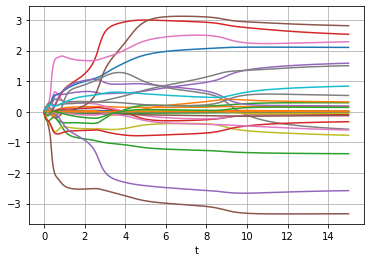

In [111]:
import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.xlim(5.9,6.1)
plt.show()

In [112]:
for i in range(coeff*N):  
    print(Y[-1][i])

0.022624343499398212
0.16054936219045193
0.2942652408977212
-0.09776140344315928
1.5866193466963128
-3.3354486766576192
-0.13051253867189438
1.5059432684616125
1.4291874372043662e-13
-8.034018329880533e-14
2.102682952502039
0.026725609073836126
-1.3717503374319753
2.531771311712737
0.1884469074170837
2.811232932884522
2.2874042063392865
-0.5709469078702206
-0.7698927741509278
-2.687828739723441e-13
4.219348512846002e-13
0.3222240653265588
-0.007576421965277909
-0.32578281095971395
-2.5787426724588185
-0.12147895708087751
-0.5971930142432156
0.5309862156767488
-0.047234251342854375
0.8382866206250887
7.80929774635146e-05
0.0011009841875811313
0.14162312532318524


In [113]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [114]:
def var_ansatz(theta,psi_0):
    psi = psi_0
    for i in range(coeff*N):
        psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

    return psi

In [115]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [116]:
psi = var_ansatz(start_point,psi_0)

In [117]:
psi_ground = eigenvec[:,0]


In [118]:
expt_value_u = np.zeros(len(time_domain))
energy = np.zeros(len(time_domain))

psi = var_ansatz(start_point,psi_0)
for tt in range(len(time_domain)):
    theta = []
    for i in range(coeff*N):
        theta.append(Y[tt][i])

    psi_var = var_ansatz(theta,psi_0)
    for i in range(L+1):
        psi_var = (Proj[i]+Proj_0[i])@psi_var
    norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))
    print(norm)

    expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
    energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)


0.9999847707708884
0.9999847720546919
0.9999847695815401
0.9999847597903496
0.9999847218610437
0.9999846404498632
0.9999845032477157
0.9999843259356714
0.999984104328738
0.9999838636733578
0.999983631092117
0.9999834122335586
0.999983195362611
0.9999829509080195
0.9999826678558599
0.99998234295922
0.9999819704655573
0.9999815481604087
0.9999810634068398
0.9999805084771486
0.9999798767158321
0.9999791607627014
0.9999783527911574
0.9999777574858612
0.9999768509660706
0.9999761002447862
0.9999749108719134
0.9999739557545997
0.9999725320251492
0.9999713387030282
0.9999696558239964
0.9999681935719009
0.9999663316002222
0.9999643143818827
0.9999624114947304
0.99996010405245
0.9999578767512494
0.9999552502099188
0.9999526758426999
0.9999498906220192
0.999946902197398
0.9999437046848348
0.9999405908393803
0.9999373044485431
0.9999338480839455
0.9999301902133197
0.9999264457286025
0.9999225395991945
0.9999184455047903
0.9999141247639872
0.9999095301349801
0.9999046115271323
0.999899320743839
0.

0.9930791365334748
0.9930813699964589
0.9930835877469455
0.9930857909038135
0.9930879805653342
0.9930901578085112
0.9930923236885121
0.9930944792382059
0.9930966254677679
0.9930987633643776
0.9931008938919786
0.9931030179911053
0.9931051365787746
0.9931072505484226
0.9931093607699105
0.9931114680895493
0.9931135733301893
0.9931156772913364
0.9931177807492985
0.9931198844573773
0.9931219891460678
0.9931240955232982
0.9931262042746808
0.9931283160637883
0.9931304315324415
0.9931325513010144
0.9931346759687567
0.9931368061141118
0.9931389422950595
0.9931410850494617
0.9931432348954039
0.9931453923315539
0.9931475578375203
0.9931497318742091
0.9931519148841839
0.9931541072920226
0.9931563095046851
0.9931585219118595
0.9931607448863259
0.9931629787843044
0.9931652239458012
0.9931674806949562
0.9931697493403764
0.9931720301754696
0.9931743234787762
0.9931766295142814
0.9931789485317298
0.9931812807669385
0.9931836264420827
0.9931859857659945
0.9931883589344367
0.9931907461303819
0.9931931475

0.9926812937041549
0.9926777634945042
0.9926742405617018
0.9926707248739608
0.9926672163991174
0.9926637151046461
0.9926602209576799
0.9926567339250219
0.9926532539731562
0.9926497810682721
0.9926463151762693
0.9926428562627846
0.9926394042931863
0.9926359592326093
0.9926325210459528
0.9926290896979046
0.9926256651529474
0.9926222473753743
0.9926188363293003
0.9926154319786796
0.9926120342873118
0.9926086432188583
0.9926052587368531
0.9926018808047136
0.9925985093857532
0.992595144443195
0.9925917859401805
0.9925884338397808
0.9925850881050132
0.9925817486988421
0.9925784155841973
0.9925750887239881
0.9925717680811038
0.9925684536184286
0.9925651452988565
0.992561843085301
0.9925585469406961
0.9925552568280153
0.9925519727102787
0.992548694550569
0.992545422312027
0.9925421559578778
0.9925388954514294
0.9925356407560889
0.9925323918353665
0.992529148652892
0.9925259111724181
0.9925226793578342
0.9925194531731719
0.9925162325826189
0.9925130175505265
0.992509808041421
0.9925066040200043

0.9935451496884279
0.9935526080530724
0.993560004978853
0.9935673409837
0.9935746165859528
0.9935818323040634
0.9935889886563366
0.9935960861606711
0.9936031253343124
0.9936101066936313
0.9936170307538982
0.9936238980290889
0.9936307090316812
0.9936374642724787
0.9936441642604419
0.9936508095025157
0.9936574005034923
0.9936639377658565
0.9936704217896587
0.9936768530723872
0.9936832321088503
0.9936895593910676
0.9936958354081714
0.993702060646305
0.9937082355885336
0.9937143607147738
0.9937204365017045
0.9937264634227021
0.9937324419477738
0.9937383725435057
0.9937442556729941
0.9937500917958108
0.9937558813679477
0.9937616248417829
0.9937673226660388
0.9937729752857513
0.993778583142247
0.9937841466731072
0.9937896663121509
0.993795142489422
0.993800575631161
0.9938059661598061
0.9938113144939749
0.9938166210484541
0.9938218862342088
0.9938271104583615
0.9938322941242047
0.9938374376311997
0.9938425413749784
0.99384760574735
0.9938526311363102
0.993857617926047
0.9938625664969535
0.99

0.9945915610542574
0.9945922648686669
0.994592966284996
0.9945936653147722
0.9945943619694502
0.9945950562604012
0.9945957481989242
0.9945964377962371
0.994597125063484
0.9945978100117306
0.9945984926519712
0.9945991729951226
0.9945998510520314
0.9946005268334664
0.994601200350128
0.9946018716126437
0.9946025406315698
0.9946032074173868
0.9946038719805155
0.9946045343312961
0.9946051944800074
0.9946058524368551
0.9946065082119827
0.994607161815459
0.9946078132572921
0.9946084625474207
0.9946091096957189
0.994609754711995
0.9946103976059958
0.9946110383873987
0.9946116770658228
0.9946123136508184
0.9946129481518812
0.9946135805784356
0.9946142109398524
0.9946148392454377
0.9946154655044388
0.9946160897260411
0.994616711919371
0.9946173320934967
0.9946179502574278
0.9946185664201149
0.9946191805904504
0.9946197927772756
0.994620402989365
0.9946210112354444
0.9946216175241829
0.9946222218641915
0.9946228242640274
0.994623424732197
0.9946240232771466
0.9946246199072729
0.9946252146309191
0

(0.95, 0.99)

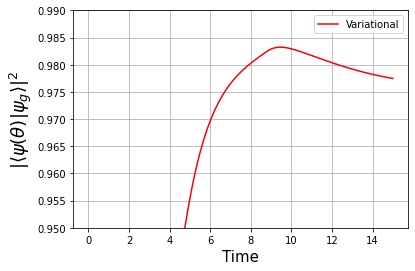

In [124]:
plt.plot(time_domain,expt_value_u, color = "red",label = "Variational")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
#plt.xlim(2.8,3)
plt.ylim(0.95,0.99)

#plt.savefig("real_time_evolution\fermion_numbers_1layer.pdf")

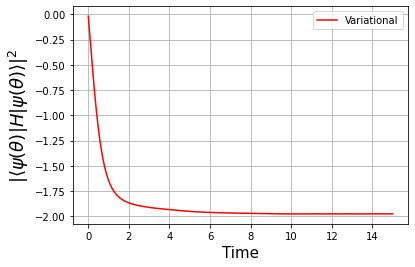

In [123]:
plt.plot(time_domain,energy, color = "red",label = "Variational")

plt.ylabel(r"$|\langle \psi(\theta)|H|\psi(\theta)\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
#plt.xlim(0,10)
#plt.ylim(-1.35,-1.25)

#plt.savefig("real_time_evolution\fermion_numbers_1layer.pdf")

In [121]:
print(expt_value_u[-1])

0.9774710750641998


In [124]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

[1 1 2 4]
[1 1 2 3 4]
[1 1 2 3 4 5]


In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
